In [4]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from utils.behavioral_analysis import calculate_median_position
from utils.data_loading_and_preprocessing import get_dlc_df, preprocess_dlc_data
from utils.session_analysis import analyze_single_session, load_session_data, perform_correlation_analyses, perform_decoding_analyses, analyze_all_sessions
from utils.visualization import plot_correlation_histogram, plot_cross_context_correlation, plot_decoding_comparison, plot_raster_pos_neg, plot_context_preference, plot_mean_speed_comparison, plot_roi, visualize_annotated_frame, plot_rotary_wheel_alignment, plot_unsorted_raster, plot_raster_pos_neg
import matplotlib.pyplot as plt
from utils.statistical_testing import run_permutation_test, categorise_neurons
import pandas as pd
from types import SimpleNamespace as Bunch
import seaborn as sns
from scipy.stats import binned_statistic_2d
from IPython.display import display
import numpy as np
import pandas as pd
import os
import glob
from scipy.io import loadmat
from pinkrigs_tools.dataset.query import load_data
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import math
import cv2

In [5]:

my_sessions = [
    ('AV043', '2024-03-04'),
    ('AV043', '2024-03-05'),
    #('AV043', '2024-03-08'),# DLC for only 5 min
    #('AV043', '2024-03-11'),  # neural recordings start only half way through
    ('AV043', '2024-03-12'), #no spikes will use as behavior baseline
    ('AV043', '2024-03-13'),
    ('AV043', '2024-03-14'),
    ('AV043', '2024-03-26'), # no spikes will use as behavior baseline
    ('EB036', '2024-03-19'),
    ('EB036', '2024-03-20'),
    ('EB036', '2024-03-22'),
    ('EB037', '2024-03-20'),
    ('EB037', '2024-03-21'),
    ('EB037', '2024-03-22'),
    ('GB011', '2024-05-09'),
    #('GB011', '2024-05-10'), # wheel not at all visited in second half 
    ('GB011', '2024-05-14'),
    ('GB011', '2024-05-15'),
    ('GB011', '2024-05-16'),
    ('GB011', '2024-05-17'),
    ('GB012', '2024-06-19'),
    ('GB012', '2024-06-20'),
    ('GB012', '2024-06-21'),
    ('GB012', '2024-06-25'),
    ('GB012', '2024-07-11'), # no spikes will use as behavior baseline
    #('GB012', '2024-07-12'), DLC for only half the sesssion
    ('GB012', '2024-07-16'),

    
]




    

In [6]:
results = analyze_all_sessions(my_sessions, correlation=True, decoding=True, leaveout=False)

AV043
2024-03-04
No probe1 data found
AV043
2024-03-05
No probe1 data found
AV043
2024-03-12
No probe0 data found
No probe1 data found
error:{e}
No spike counts were provided
No spike counts were provided
AV043
2024-03-13
No probe1 data found
AV043
2024-03-14
No probe1 data found
AV043
2024-03-26
No probe0 data found
No probe1 data found
error:{e}
No spike counts were provided
No spike counts were provided
EB036
2024-03-19
EB036
2024-03-20
EB036
2024-03-22
EB037
2024-03-20
EB037
2024-03-21
EB037
2024-03-22
GB011
2024-05-09
GB011
2024-05-14
GB011
2024-05-15
GB011
2024-05-16
GB011
2024-05-17
GB012
2024-06-19
GB012
2024-06-20
GB012
2024-06-21
GB012
2024-06-25
GB012
2024-07-11
No probe0 data found
No probe1 data found
error:{e}
No spike counts were provided
No spike counts were provided
GB012
2024-07-16


In [7]:
run_permutation_test(results)

In [104]:
print(results[0].spike_counts.shape[0])

674


In [121]:
arena_percentages  = []
wheel_percentages = []

for result in results:
        if result.spike_counts is None:
             continue
        sig_arena = result.permutation.significant.arena
        sig_wheel = result.permutation.significant.wheel

        n_neurons= result.spike_counts.shape[0]
        perc_arena= np.sum(sig_arena) / n_neurons * 100
        perc_wheel= np.sum(sig_wheel) / n_neurons * 100

        arena_percentages.append(perc_arena)
        wheel_percentages.append(perc_wheel)
        
       

In [122]:
print(np.median(arena_percentages))
print(np.percentile(arena_percentages, 25))
print(np.percentile(arena_percentages, 75))
print(np.median(wheel_percentages))
print(np.percentile(wheel_percentages, 25))
print(np.percentile(wheel_percentages, 75))

61.35194993722536
47.19600320120516
66.9883564711151
55.27657527657527
32.103672189879084
66.64902447701226


In [ ]:
rels_arena  = []
rels_wheel = []

for result in results:
        if result.spike_counts is None:
             continue
        rel_arena = result.correlations.reliability_arena
        rel_wheel = result.correlations.reliability_wheel

        rels_arena.append(rel_arena)
        rels_wheel.append(rel_wheel)
        

In [140]:
print(np.median(rels_arena))
print(np.percentile(rels_arena, 25))
print(np.percentile(rels_arena, 75))
print(np.median(rels_wheel))
print(np.percentile(rels_wheel, 25))
print(np.percentile(rels_wheel, 75))

from scipy.stats import wilcoxon

statistic_arena, p_value_arena = wilcoxon(rels_arena, alternative='greater')

print(p_value_arena)
print(statistic_arena)

statistic_wheel, p_value_wheel = wilcoxon(rels_wheel, alternative='greater')

print(p_value_wheel)
print(statistic_wheel)

0.8455538663574372
0.7321292330676527
0.8847933623050221
0.8277364511627737
0.6635830560877982
0.8895373808412499
9.5367431640625e-07
210.0
9.5367431640625e-07
210.0


In [141]:
cross_l  = []


for result in results:
        if result.spike_counts is None:
             continue
        cross = result.correlations.cross_context
    

        cross_l.append(cross)
        

In [143]:
print(cross_l)

[0.29200624533922726, 0.2585985614011502, 0.010354111852897056, 0.022178875782319304, 0.0636670200299394, 0.09188125608767593, -4.267621419530604e-05, 0.046445229141453194, 0.10178576742778588, -0.07971060152628161, 0.32083776910091977, 0.22101696511684518, -0.1049920999656428, -0.1937231789711958, -0.07264278099194771, 0.25606731858558, 0.2675871639813749, 0.30061388849689097, 0.34203795007968535, 0.2643982529487086]


In [142]:
print(np.median(cross_l))
print(np.percentile(cross_l, 25))
print(np.percentile(cross_l, 75))

0.0968335117577309
0.007754914836123965
0.26519548070687515


In [1304]:
within_arena  = []
within_wheel= []


for result in results:
        if result.spike_counts is None:
             continue
        arena = result.decoding.performance.arena_to_arena[0,1]
        wheel= result.decoding.performance.wheel_to_wheel[0,1]
    

        within_arena.append(arena)
        within_wheel.append(wheel)

In [1305]:
print(np.mean(within_arena))
print(np.percentile(within_arena, 25))
print(np.percentile(within_arena, 75))
print(np.mean(within_wheel))
print(np.percentile(within_wheel, 25))
print(np.percentile(within_wheel, 75))

0.4187192178009269
0.15956095235235046
0.6401304663124784
0.5828008731152843
0.2804840840126884
0.8534787266468958


In [1291]:
cross_arena  = []
cross_wheel= []


for result in results:
        if result.spike_counts is None:
             continue
        arena = result.decoding.performance.arena_to_wheel[0,1]
        wheel= result.decoding.performance.wheel_to_arena[0,1]
    

        cross_arena.append(arena)
        cross_wheel.append(wheel)

In [1292]:
print(np.mean(cross_arena))
print(np.percentile(cross_arena, 25))
print(np.percentile(cross_arena, 75))
print(np.mean(cross_wheel))
print(np.percentile(cross_wheel, 25))
print(np.percentile(cross_wheel, 75))

0.3521006830673677
0.2084534110227374
0.5226414500984399
-0.016211884841233877
-0.06822324599677976
0.0633432632865968


In [1303]:
print(len(cross_arena))

20


In [1306]:
statistic, p_value = wilcoxon(within_arena, cross_arena, alternative='greater')

In [1307]:
print(p_value)

0.06636333465576172


In [1308]:
statistic, p_value = wilcoxon(within_wheel, cross_wheel, alternative='greater')

In [1314]:
statistic, p_value = wilcoxon(cross_wheel, alternative='greater')
print(p_value)

0.4927177429199219


In [1315]:
statistic, p_value = wilcoxon(cross_arena, alternative='greater')
print(p_value)

9.5367431640625e-07


In [ ]:
rels  = []
stabs = []

for result in results:
        if result.spike_counts is None:
             continue
        rel = result.correlations.reliability
        stab = result.correlations.stability

        rels.append(rel)
        stabs.append(stab)

In [146]:
print(np.median(rels))
print(np.percentile(rels, 25))
print(np.percentile(rels, 75))

print(np.median(stabs))
print(np.percentile(stabs, 25))
print(np.percentile(stabs, 75))

0.7994504406196894
0.7047878924106159
0.8726475660887395
0.11649100789448637
0.009279026484100885
0.2540673939599422


In [147]:
statistic, p_value = wilcoxon(rels, stabs, alternative='greater')

In [1372]:
time = []

for result in results:
        if result.spike_counts is None:
             continue
        total_time = (len(result.behavior.mask_arena) * result.metadata.bin_width) / 60

        time.append(total_time)
       

In [1375]:
print(np.mean(time))
print(np.std(time))

56.506083333333336
19.311333720807298


In [1428]:
arena_pos_mo = []
wheel_pos_mo = []
arena_neg_mo= []
wheel_neg_mo= []
arena_total_mo=[]
wheel_total_mo = []




for result in results:
        if result.spike_counts is None:
             continue
        
        sig_arena = result.permutation.significant.arena
        sig_wheel = result.permutation.significant.wheel

        if result.metadata.subject_id[:2] == 'EB':
            continue
        else:
          arena_total_mo.append(np.sum(sig_arena))
          wheel_total_mo.append(np.sum(sig_wheel))

        
        


        

In [1429]:
print(np.median(arena_total_mo))
print(np.percentile(arena_total_mo, 25))
print(np.percentile(arena_total_mo, 75))
print(np.median(wheel_total_mo))
print(np.percentile(wheel_total_mo, 25))
print(np.percentile(wheel_total_mo, 75))



464.0
377.5
962.0
553.0
432.0
971.5


In [1430]:
statistic_mo, p_value_mo = wilcoxon(arena_total_mo, wheel_total_mo, alternative='greater')

In [1431]:
print(p_value_mo)

0.83709716796875


In [1432]:
arena_pos_hc = []
wheel_pos_hc = []
arena_neg_hc= []
wheel_neg_hc= []
arena_total_hc=[]
wheel_total_hc = []




for result in results:
        if result.spike_counts is None:
             continue
        
        sig_arena = result.permutation.significant.arena
        sig_wheel = result.permutation.significant.wheel

        if result.metadata.subject_id == 'EB036':
            arena_total_hc.append(np.sum(sig_arena))
            wheel_total_hc.append(np.sum(sig_wheel))
        else:
              continue
          

In [1434]:
print(np.median(arena_total_hc))
print(np.percentile(arena_total_hc, 25))
print(np.percentile(arena_total_hc, 75))
print(np.median(wheel_total_hc))
print(np.percentile(wheel_total_hc, 25))
print(np.percentile(wheel_total_hc, 75))

379.0
375.0
398.5
148.0
123.0
160.0


In [1435]:
statistic_hc, p_value_hc = wilcoxon(arena_total_hc, wheel_total_hc, alternative='greater')

In [1436]:
print(p_value_hc)

0.125


In [ ]:
arena_pos_sc = []
wheel_pos_sc = []
arena_neg_sc= []
wheel_neg_sc= []
arena_total_sc=[]
wheel_total_sc = []




for result in results:
        if result.spike_counts is None:
             continue
        
        sig_arena = result.permutation.significant.arena
        sig_wheel = result.permutation.significant.wheel

        pos_sig_arena = sig_arena & (result.correlations.arena > 0)
        neg_sig_arena= sig_wheel & (result.correlations.arena < 0)

        pos_sig_wheel = sig_wheel & (result.correlations.wheel > 0)
        neg_sig_arena`_sig_wheel = sig_wheel & (result.correlations.wheel > 0)

        if result.metadata.subject_id == 'EB037':
            arena_total_sc.append(np.sum(sig_arena))
            wheel_total_sc.append(np.sum(sig_wheel))
            arena_pos_sc.append(np.sum(pos_sig_arena))
            arena_neg_sc.append(np.sum(pos_sig_arena))
            wheel_pos_sc.append(np.sum(pos_sig_wheel))
        else:
              continue

In [1438]:
print(np.median(arena_total_sc))
print(np.percentile(arena_total_sc, 25))
print(np.percentile(arena_total_sc, 75))
print(np.median(wheel_total_sc))
print(np.percentile(wheel_total_sc, 25))
print(np.percentile(wheel_total_sc, 75))

356.0
257.5
449.5
137.0
96.5
204.5


In [ ]:
print(len)

In [1439]:
statistic_sc, p_value_sc = wilcoxon(arena_total_sc, wheel_total_sc, alternative='greater')

In [1440]:
print(p_value_sc)

0.125


In [2542]:
result= results[12]
corr_arena= result.correlations.arena
corr_wheel= result.correlations.wheel
sig_arena= result.permutation.significant.arena
sig_wheel=result.permutation.significant.wheel

In [2543]:
categories = categorise_neurons(corr_arena, corr_wheel, sig_arena, sig_wheel)

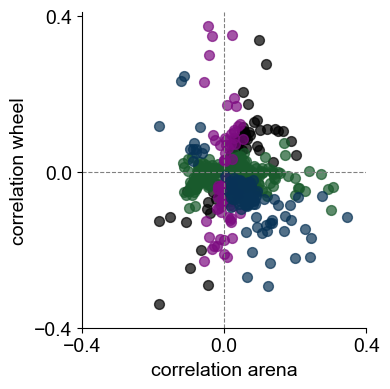

In [2544]:

labels = ['Context invariant', 'Arena only', 'Wheel only', 'Context switching']
colors = ["#000000", '#195A2C', '#7D0C81', '#083356']
category_fields = [categories.context_invariant, categories.arena_only, categories.wheel_only, categories.context_switching]

# Create the scatter plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the data for each category with its specific color
for i in range(len(labels)):
    # Get the boolean mask for the current category
    mask = category_fields[i]
    
    # Use the mask to select the relevant data points
    ax.scatter(corr_arena[mask], corr_wheel[mask], 
               c=colors[i], label=labels[i], alpha=0.7, s=50)


ax.set_xlabel('correlation arena', fontsize=14)
ax.set_ylabel('correlation wheel', fontsize=14)




# Optional: Add lines to indicate zero correlation
ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
ax.axvline(0, color='gray', linewidth=0.8, linestyle='--')
ax.set_xticks(np.arange(-0.4, 0.41, 0.4))
ax.set_yticks(np.arange(-0.4, 0.41, 0.4))
ax.tick_params(axis='both', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_thesis\categories_GB.svg', 
            #bbox_inches='tight', dpi=300)

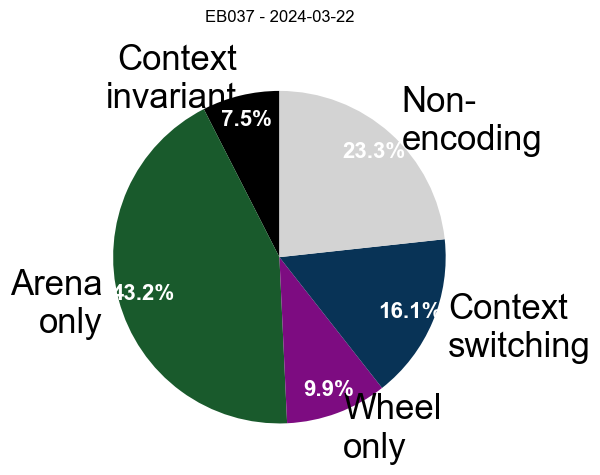

In [2545]:
# Extract counts from your categories bunch
counts = [
    np.sum(categories.context_invariant),
    np.sum(categories.arena_only),
    np.sum(categories.wheel_only),
    np.sum(categories.context_switching),
    np.sum(categories.non_encoding)
]

labels = ['Context\ninvariant', 'Arena\nonly', 'Wheel\nonly', 'Context\nswitching', 'Non-\nencoding']
colors = ["#000000", '#195A2C', '#7D0C81', '#083356', '#D3D3D3']

# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%',
                                   startangle=90, pctdistance=0.85,
                                   textprops={'fontsize': 500})  # Increased from 10 to 14

# Make percentage text bold and bigger
for autotext in autotexts:
    autotext.set_weight('bold')
    autotext.set_color('white')
    autotext.set_fontsize(16)  # Set percentage font size explicitly

# Make label text bigger
for text in texts:
    text.set_fontsize(25)  # Set label font size explicitly

ax.set_title(f'{result.metadata.subject_id} - {result.metadata.date}', fontsize=12, pad=20)
plt.tight_layout()
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_thesis\pie_GB.svg')


In [2549]:
ci = []
ao = []
wo= []
cs= []
ne= []

for result in results:
    if result.spike_counts is None:
             continue
    
    if result.metadata.subject_id[:2] == "EB":
    
        context_inv = np.sum(categories.context_invariant) / result.spike_counts.shape[0] * 100,
        arena_only = np.sum(categories.arena_only) / result.spike_counts.shape[0] * 100,
        wheel_only =np.sum(categories.wheel_only) / result.spike_counts.shape[0] * 100,
        context_swi =np.sum(categories.context_switching) / result.spike_counts.shape[0]* 100,
        non_encoding=np.sum(categories.non_encoding)  / result.spike_counts.shape[0] * 100
        
        ci.append(context_inv)
        ao.append(arena_only)
        wo.append(wheel_only)
        cs.append(context_swi)
        ne.append(non_encoding)
    
    else:
          continue




In [2550]:
print(ci)


[(11.380597014925373,), (9.902597402597403,), (10.645724258289704,), (9.45736434108527,), (10.815602836879433,), (7.512315270935961,)]


In [ ]:
plt.scatter(corr_arena, corr_wheel)

In [8]:
def compute_speed_tuning(spike_counts, speed, mask, speed_bins, dt=0.1):
    # Only use data from this context
    context_speed = speed[mask]
    context_spikes = spike_counts[:, mask]
    
    bin_centers = 0.5 * (speed_bins[:-1] + speed_bins[1:])
    n_neurons = spike_counts.shape[0]
    n_bins = len(bin_centers)
    
    # Initialize
    firing_rates = np.zeros((n_neurons, n_bins))
    firing_sem = np.zeros((n_neurons, n_bins))
    
    # Digitize speeds
    speed_indices = np.digitize(context_speed, speed_bins) - 1
    
    # Calculate firing rates
    for i in range(n_bins):
        idx = speed_indices == i
        if np.sum(idx) > 30:  # Minimum 5 time bins
            rates_in_bin = context_spikes[:, idx] / dt
            firing_rates[:, i] = np.mean(rates_in_bin, axis=1)
            firing_sem[:, i] = np.std(rates_in_bin, axis=1) / np.sqrt(np.sum(idx))
        else:
            firing_rates[:, i] = np.nan
            firing_sem[:, i] = np.nan
    
    return bin_centers, firing_rates, firing_sem

In [48]:
i=19
spike_counts = results[i].spike_counts
speed_arena = results[i].behavior.speed_arena
speed_wheel = results[i].behavior.speed_wheel
mask_arena = results[i].behavior.mask_arena
mask_wheel = results[i].behavior.mask_wheel
corr_arena = results[i].correlations.arena
corr_wheel = results[i].correlations.wheel
sig_arena = results[i].permutation.significant.arena
sig_wheel = results[i].permutation.significant.wheel

In [49]:
max_speed_arena = np.nanmax(speed_arena[mask_arena])
max_speed_wheel = np.nanmax(speed_wheel[mask_wheel])

# Create bins with same width
bin_width = 2.0  # cm/s
arena_bins = np.arange(0, max_speed_arena + bin_width, bin_width)
wheel_bins = np.arange(0, max_speed_wheel + bin_width, bin_width)

# Compute tuning curves
arena_centers, oa_tuning, oa_sem = compute_speed_tuning(
    spike_counts, speed_arena, mask_arena, arena_bins)
wheel_centers, wh_tuning, wh_sem = compute_speed_tuning(
    spike_counts, speed_wheel, mask_wheel, wheel_bins)

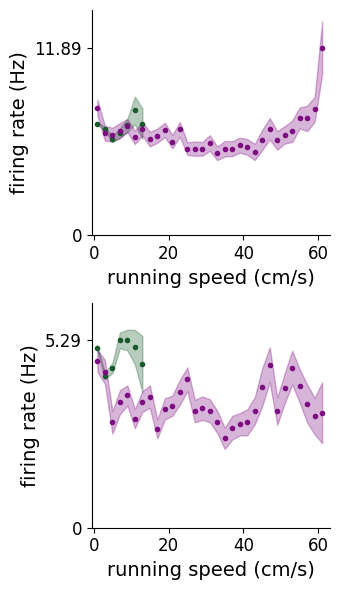

In [50]:
# Fix the correlation assignment first
corr_arena = results[i].correlations.arena  # Fixed: use .arena, not .wheel
corr_wheel = results[i].correlations.wheel

# Identify arena-only neurons (significant in arena, not in wheel)
arena_only_mask = ~sig_arena & ~sig_wheel
arena_only_indices = np.where(arena_only_mask)[0]

# Get correlations for arena-only neurons
arena_only_corr = corr_arena[arena_only_mask]

# Define percentiles to plot - only 100th and 75th
percentiles = [50, 25]

# Create 2x1 subplot (vertically stacked)
fig, axes = plt.subplots(2, 1, figsize=(3.5, 6))

for idx, pct in enumerate(percentiles):
    ax = axes[idx]
    
    # Find the percentile value among arena-only neurons
    percentile_value = np.percentile(np.abs(arena_only_corr), pct)
    
    # Find which arena-only neuron is closest to this percentile
    idx_in_arena_only = np.argmin(np.abs(np.abs(arena_only_corr) - percentile_value))
    neuron_idx = arena_only_indices[idx_in_arena_only]
    
    # Get max rate for this neuron
    max_rate = max(np.nanmax(oa_tuning[neuron_idx, :]), 
                   np.nanmax(wh_tuning[neuron_idx, :]))
    
    # Plot arena with shaded error region
    ax.fill_between(arena_centers, 
                    oa_tuning[neuron_idx, :] - oa_sem[neuron_idx, :],
                    oa_tuning[neuron_idx, :] + oa_sem[neuron_idx, :],
                    color='#195A2C', alpha=0.3)
    ax.plot(arena_centers, oa_tuning[neuron_idx, :], 
            'o', color='#195A2C', markersize=3)
    
    # Plot wheel with shaded error region
    ax.fill_between(wheel_centers, 
                    wh_tuning[neuron_idx, :] - wh_sem[neuron_idx, :],
                    wh_tuning[neuron_idx, :] + wh_sem[neuron_idx, :],
                    color='#7D0C81', alpha=0.3)
    ax.plot(wheel_centers, wh_tuning[neuron_idx, :], 
            'o', color='#7D0C81', markersize=3)
    
    # Styling
    ax.set_xlabel('running speed (cm/s)', fontsize=14)
    ax.set_ylabel('firing rate (Hz)', fontsize=14)
    
    # Format y-axis with rounded max value
    max_rate_rounded = round(max_rate, 2)
    ax.set_yticks([0, max_rate_rounded])
    ax.set_yticklabels(['0', f'{max_rate_rounded:.2f}'])
    
    ax.set_xlim(-0.5, max(max_speed_arena, max_speed_wheel) + 0.5)
    ax.set_ylim(0, max_rate * 1.2)  # Add 30% padding above max
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=12)

#axes[1].set_ylim(0, max_rate * 1.5)  # Add 30% padding above max

plt.tight_layout()
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_thesis\non_encoding_GB.svg', 
            bbox_inches='tight', dpi=300)

In [1144]:
data = results[21]
speed_arena = data.behavior.speed_arena
speed_wheel = data.behavior.speed_wheel
mask_arena = data.behavior.mask_arena
mask_wheel = data.behavior.mask_wheel
spike_counts = data.spike_counts
corr_arena = data.correlations.arena
corr_wheel = data.correlations.wheel

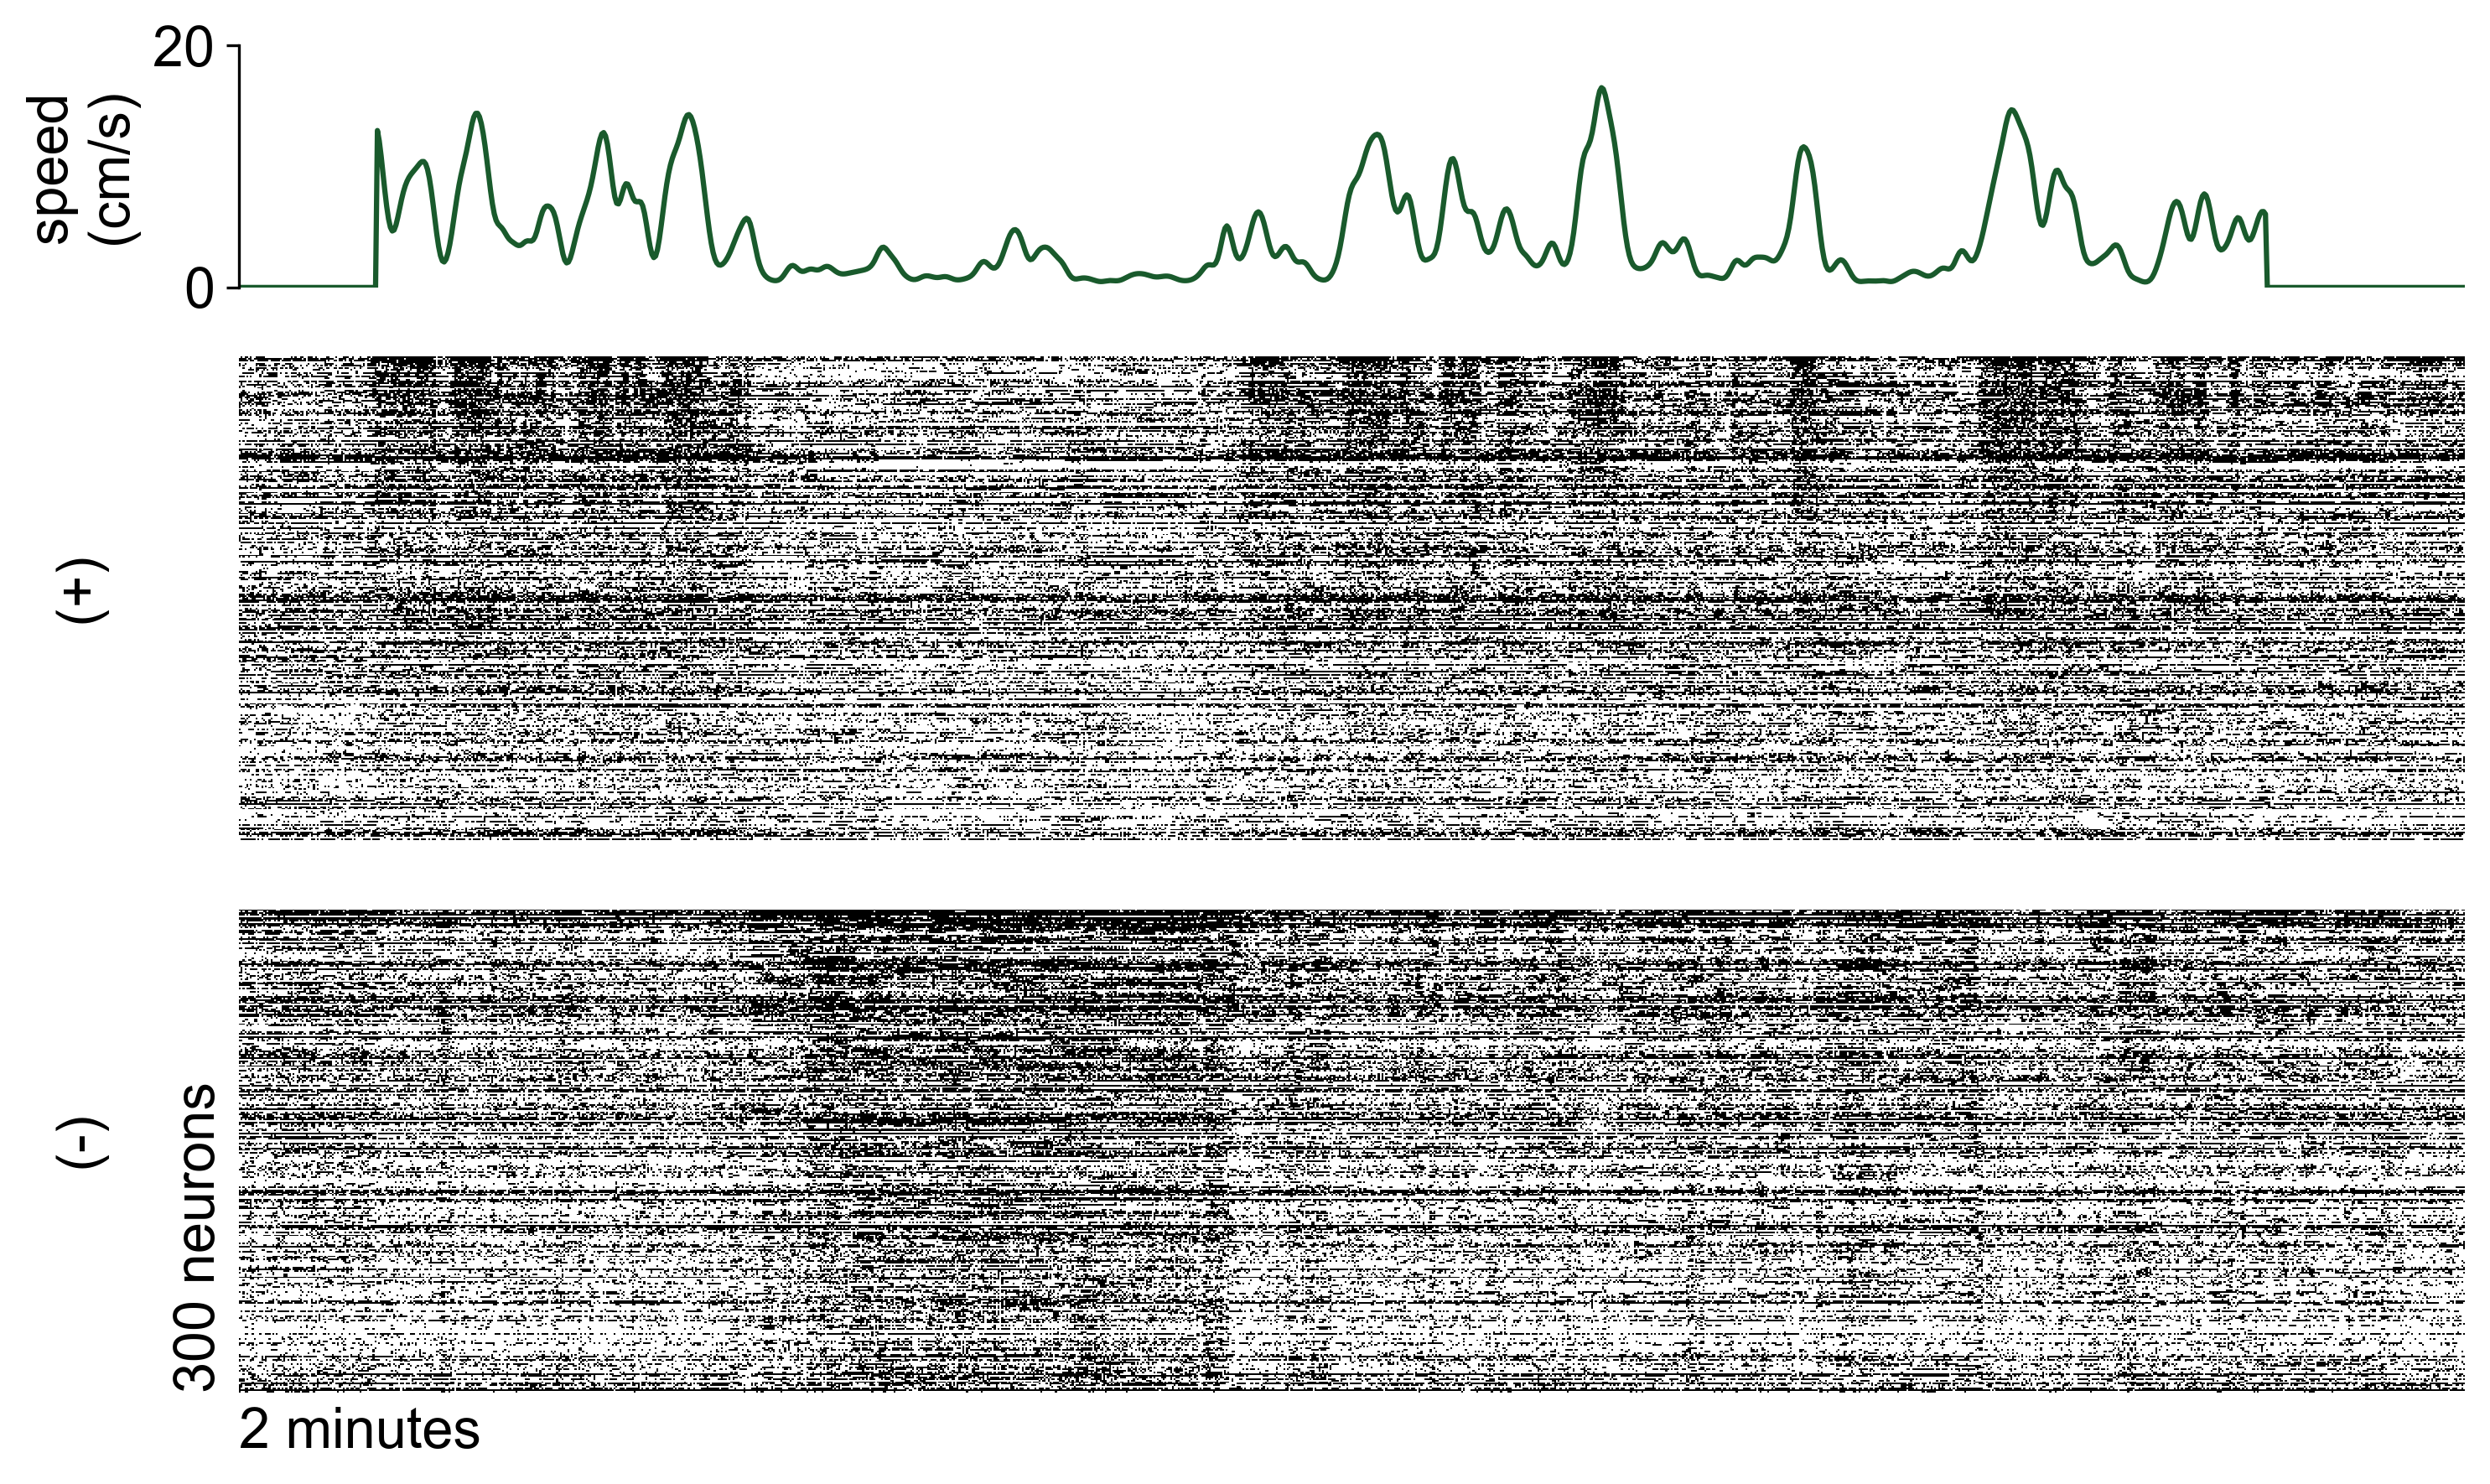

In [1189]:
plot_raster_pos_neg(spike_counts, speed_arena, mask_arena, corr_arena, color="#195A2C", n_neurons=300, w_start=3600, w_end=4800, save_path='arena_raster_300_neurons', save=True)

In [958]:
print(sessions)

[('AV043', '2024-03-04'), ('AV043', '2024-03-05'), ('AV043', '2024-03-12'), ('AV043', '2024-03-13'), ('AV043', '2024-03-14'), ('AV043', '2024-03-26'), ('EB036', '2024-03-15'), ('EB036', '2024-03-19'), ('EB036', '2024-03-20'), ('EB036', '2024-03-22'), ('EB037', '2024-03-20'), ('EB037', '2024-03-21'), ('EB037', '2024-03-22'), ('GB011', '2024-05-09'), ('GB011', '2024-05-14'), ('GB011', '2024-05-15'), ('GB011', '2024-05-16'), ('GB011', '2024-05-17'), ('GB012', '2024-06-19'), ('GB012', '2024-06-20'), ('GB012', '2024-06-21'), ('GB012', '2024-06-25'), ('GB012', '2024-07-11'), ('GB012', '2024-07-16')]


In [1146]:
i=21
spike_counts = results[i].spike_counts
speed_arena = results[i].behavior.speed_arena
speed_wheel = results[i].behavior.speed_wheel
mask_arena = results[i].behavior.mask_arena
mask_wheel = results[i].behavior.mask_wheel
corr_wheel = results[i].correlations.wheel

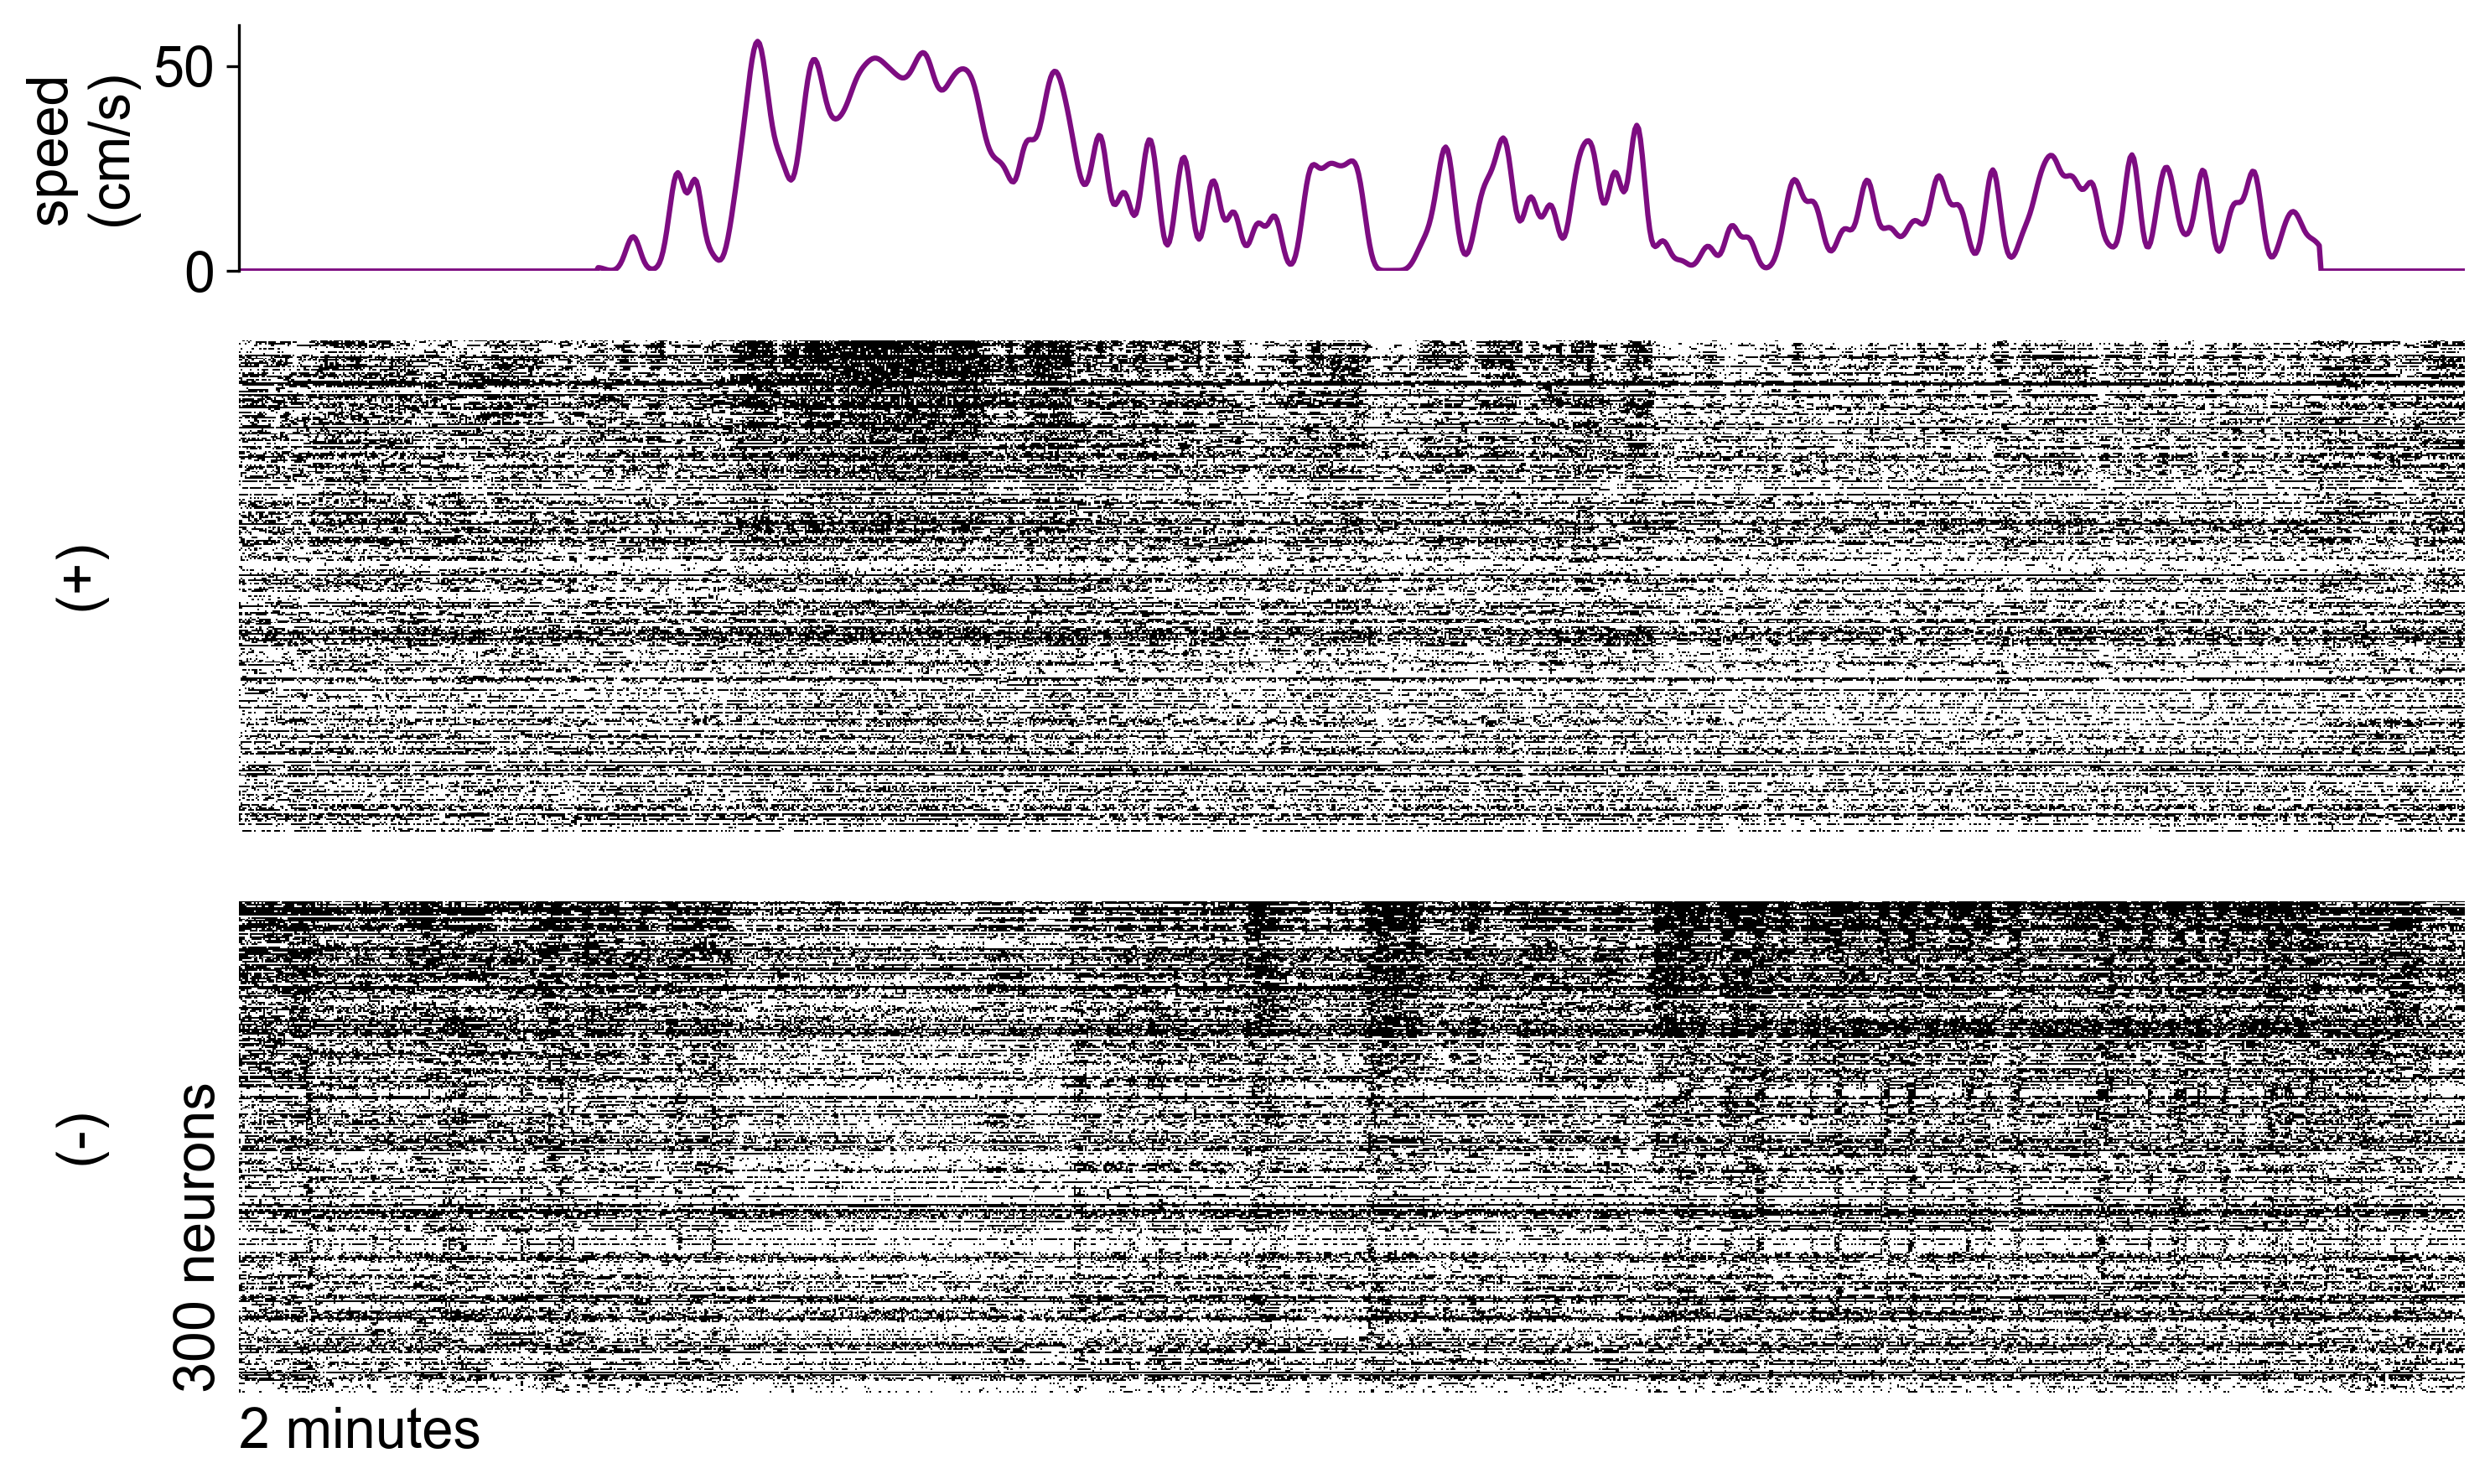

In [1190]:
plot_raster_pos_neg(spike_counts, speed_wheel, mask_wheel, corr_wheel, color="#7D0C81", n_neurons=300, w_start=4500, w_end=5700, save_path='wheel_raster_300_neurons', save=True)


In [1049]:
corr_arena = results[18].correlations.arena
corr_wheel = results[18].correlations.wheel
p_vals_arena = results[18].permutation.p_vals.arena


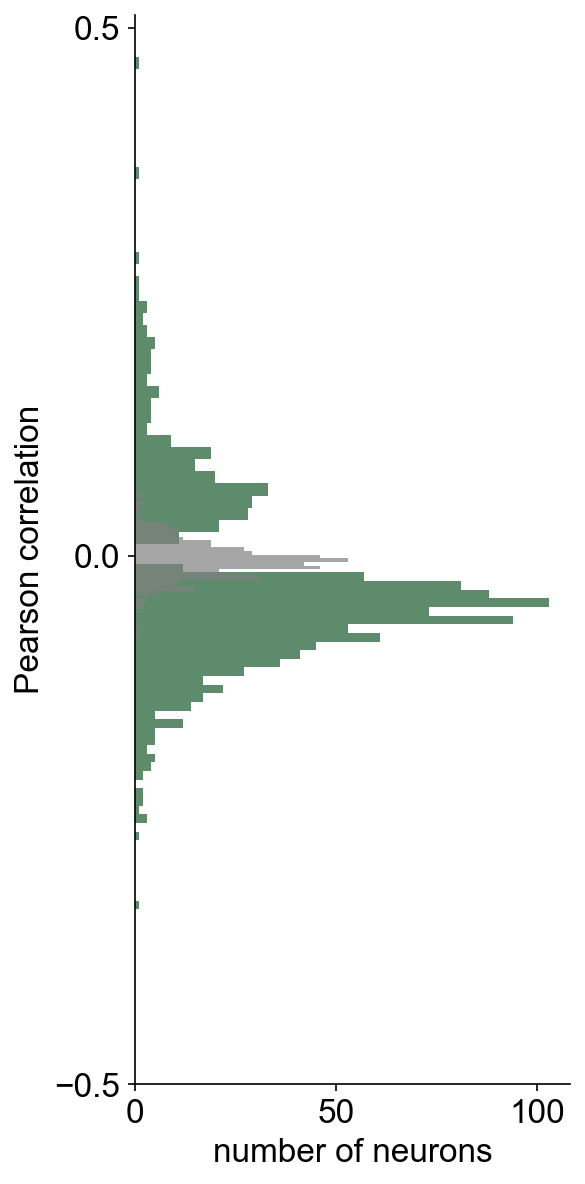

In [1052]:
plot_correlation_histogram(corr_arena,p_vals_arena, color="#195A2C", save_path='arena_correlation_histogram', save=True)

In [1053]:
corr_arena = results[18].correlations.arena
corr_wheel = results[18].correlations.wheel
p_vals_wheel = results[18].permutation.p_vals.wheel

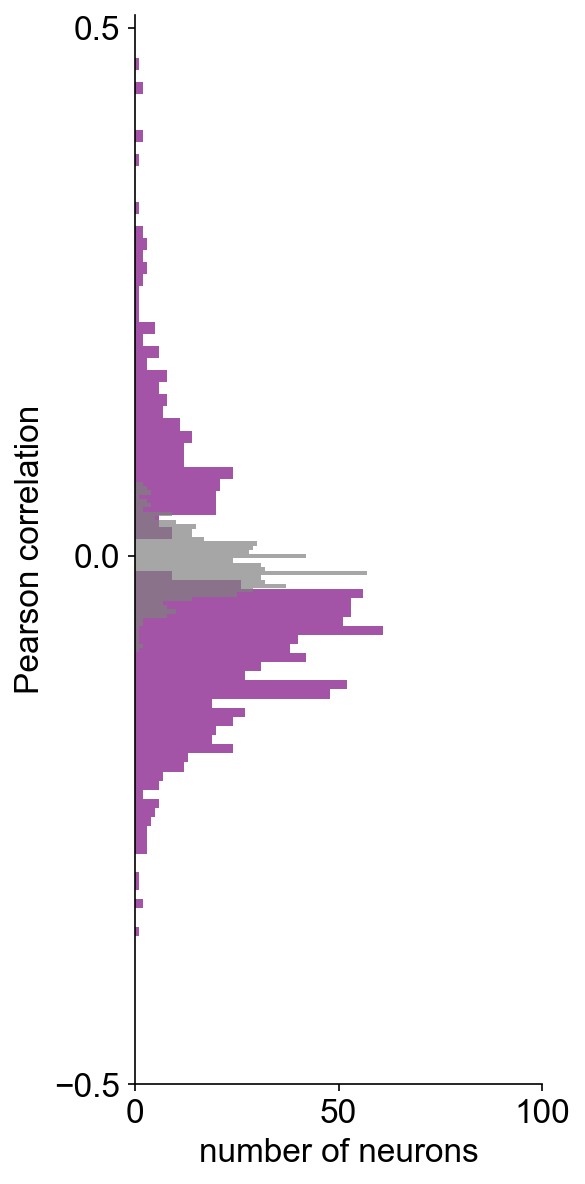

In [1054]:

plot_correlation_histogram(corr_wheel,p_vals_wheel, color="#7D0C81", save_path='wheel_correlation_histogram', save=True)

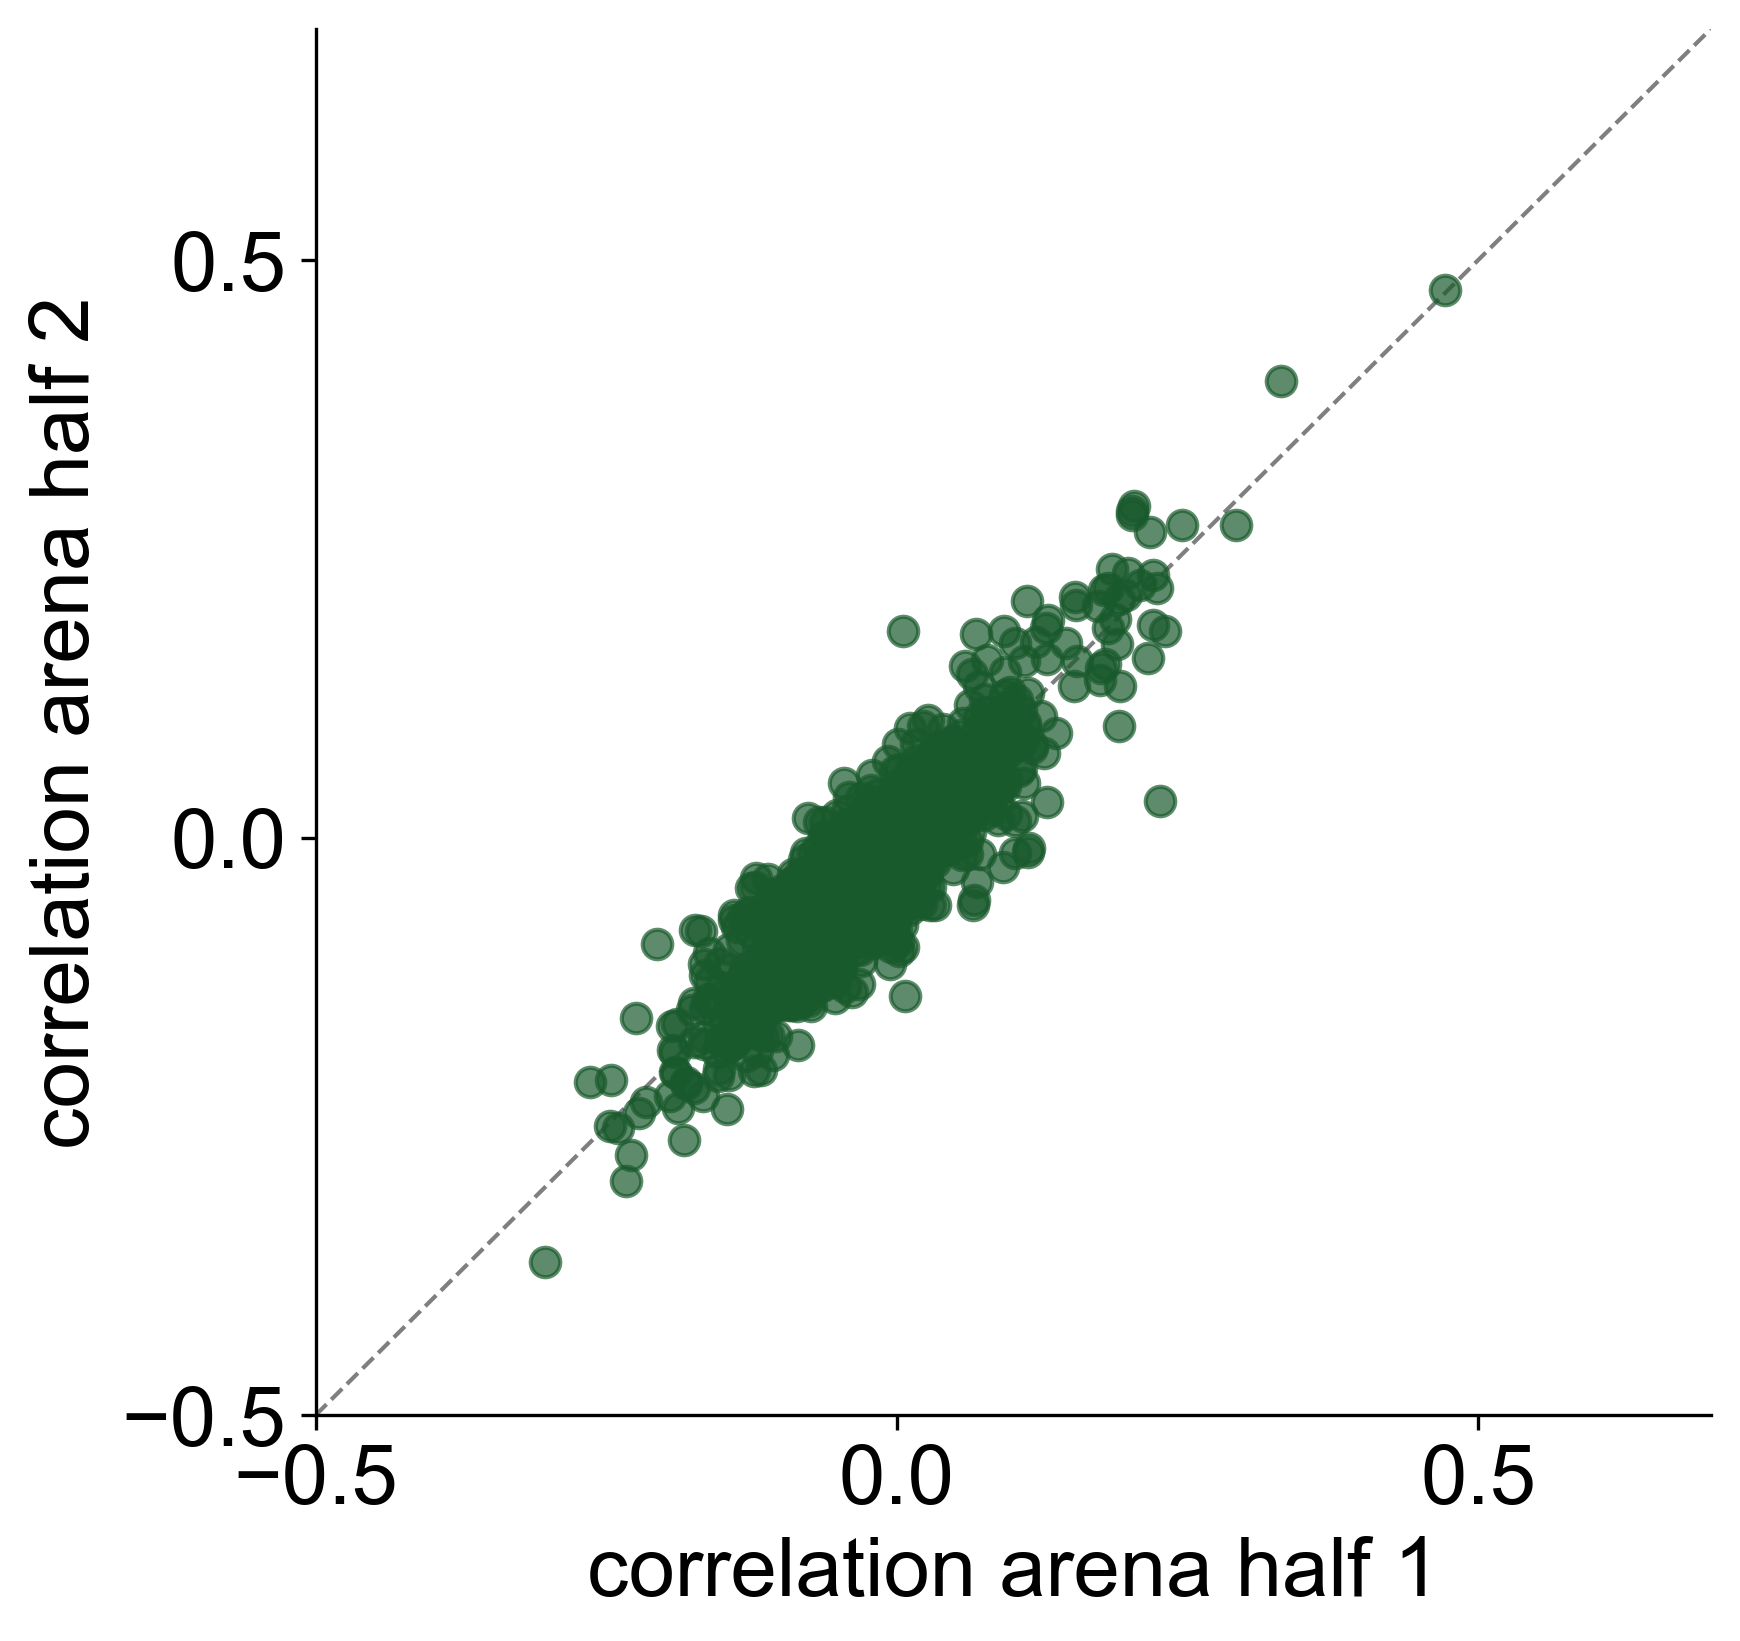

In [1183]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
ax.scatter(results[18].correlations.arena_half1, results[18].correlations.arena_half2, alpha=0.7, color="#195A2C", zorder=2, s=50)
ax.set_xlabel('correlation arena half 1', fontsize=20)
ax.set_ylabel('correlation arena half 2', fontsize=20)
ax.plot([-0.5, 0.7], [-0.5, 0.7], 'k-', linewidth=1, alpha=0.5, zorder=1, ls='--')
ax.set_xlim(-0.5, 0.7)
ax.set_ylim(-0.5, 0.7)
ax.set_xticks(np.arange(-0.5, 0.51, 0.5))  
ax.set_yticks(np.arange(-0.5, 0.51, 0.5))
ax.tick_params(axis='both', labelsize=20)
ax.spines[['right', 'top']].set_visible(False)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\arena_half_correlation_MOs.png', bbox_inches='tight', dpi=300)



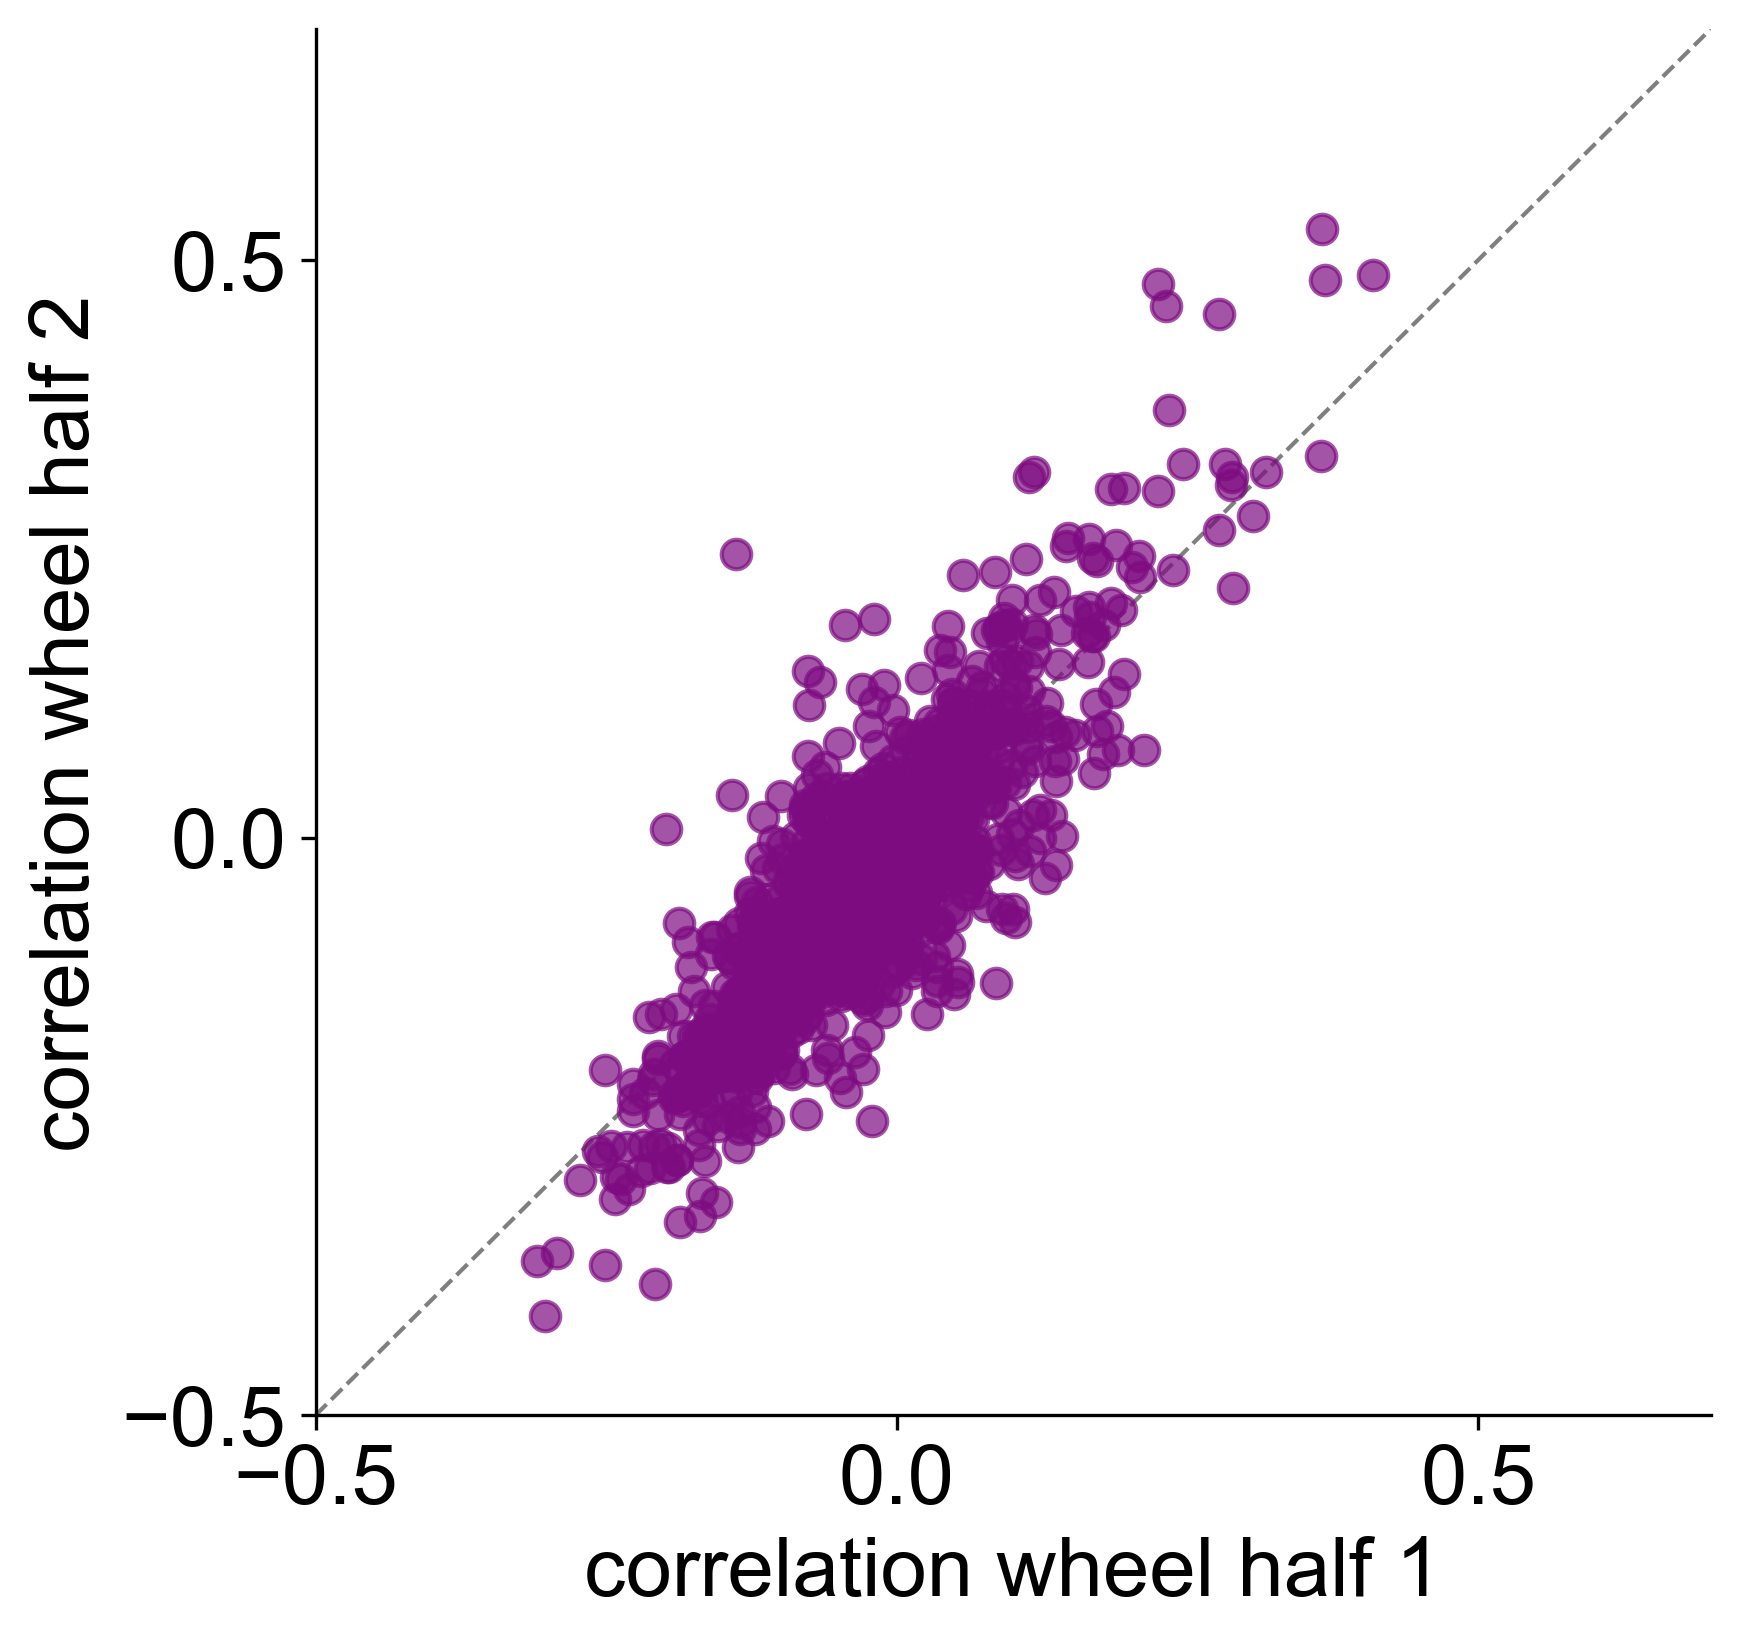

In [1182]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
ax.scatter(results[18].correlations.wheel_half1, results[18].correlations.wheel_half2, alpha=0.7, color="#7D0C81", zorder=2, s=50)
ax.set_xlabel('correlation wheel half 1', fontsize=20)
ax.set_ylabel('correlation wheel half 2', fontsize=20)
ax.plot([-0.5, 0.7], [-0.5, 0.7], 'k-', linewidth=1, alpha=0.5, zorder=1, ls='--')
ax.set_xlim(-0.5, 0.7)
ax.set_ylim(-0.5, 0.7)
ax.set_xticks(np.arange(-0.5, 0.51, 0.5))  
ax.set_yticks(np.arange(-0.5, 0.51, 0.5))
ax.tick_params(axis='both', labelsize=20)
ax.spines[['right', 'top']].set_visible(False)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\wheel_half_correlation_MOs.png', bbox_inches='tight', dpi=300)

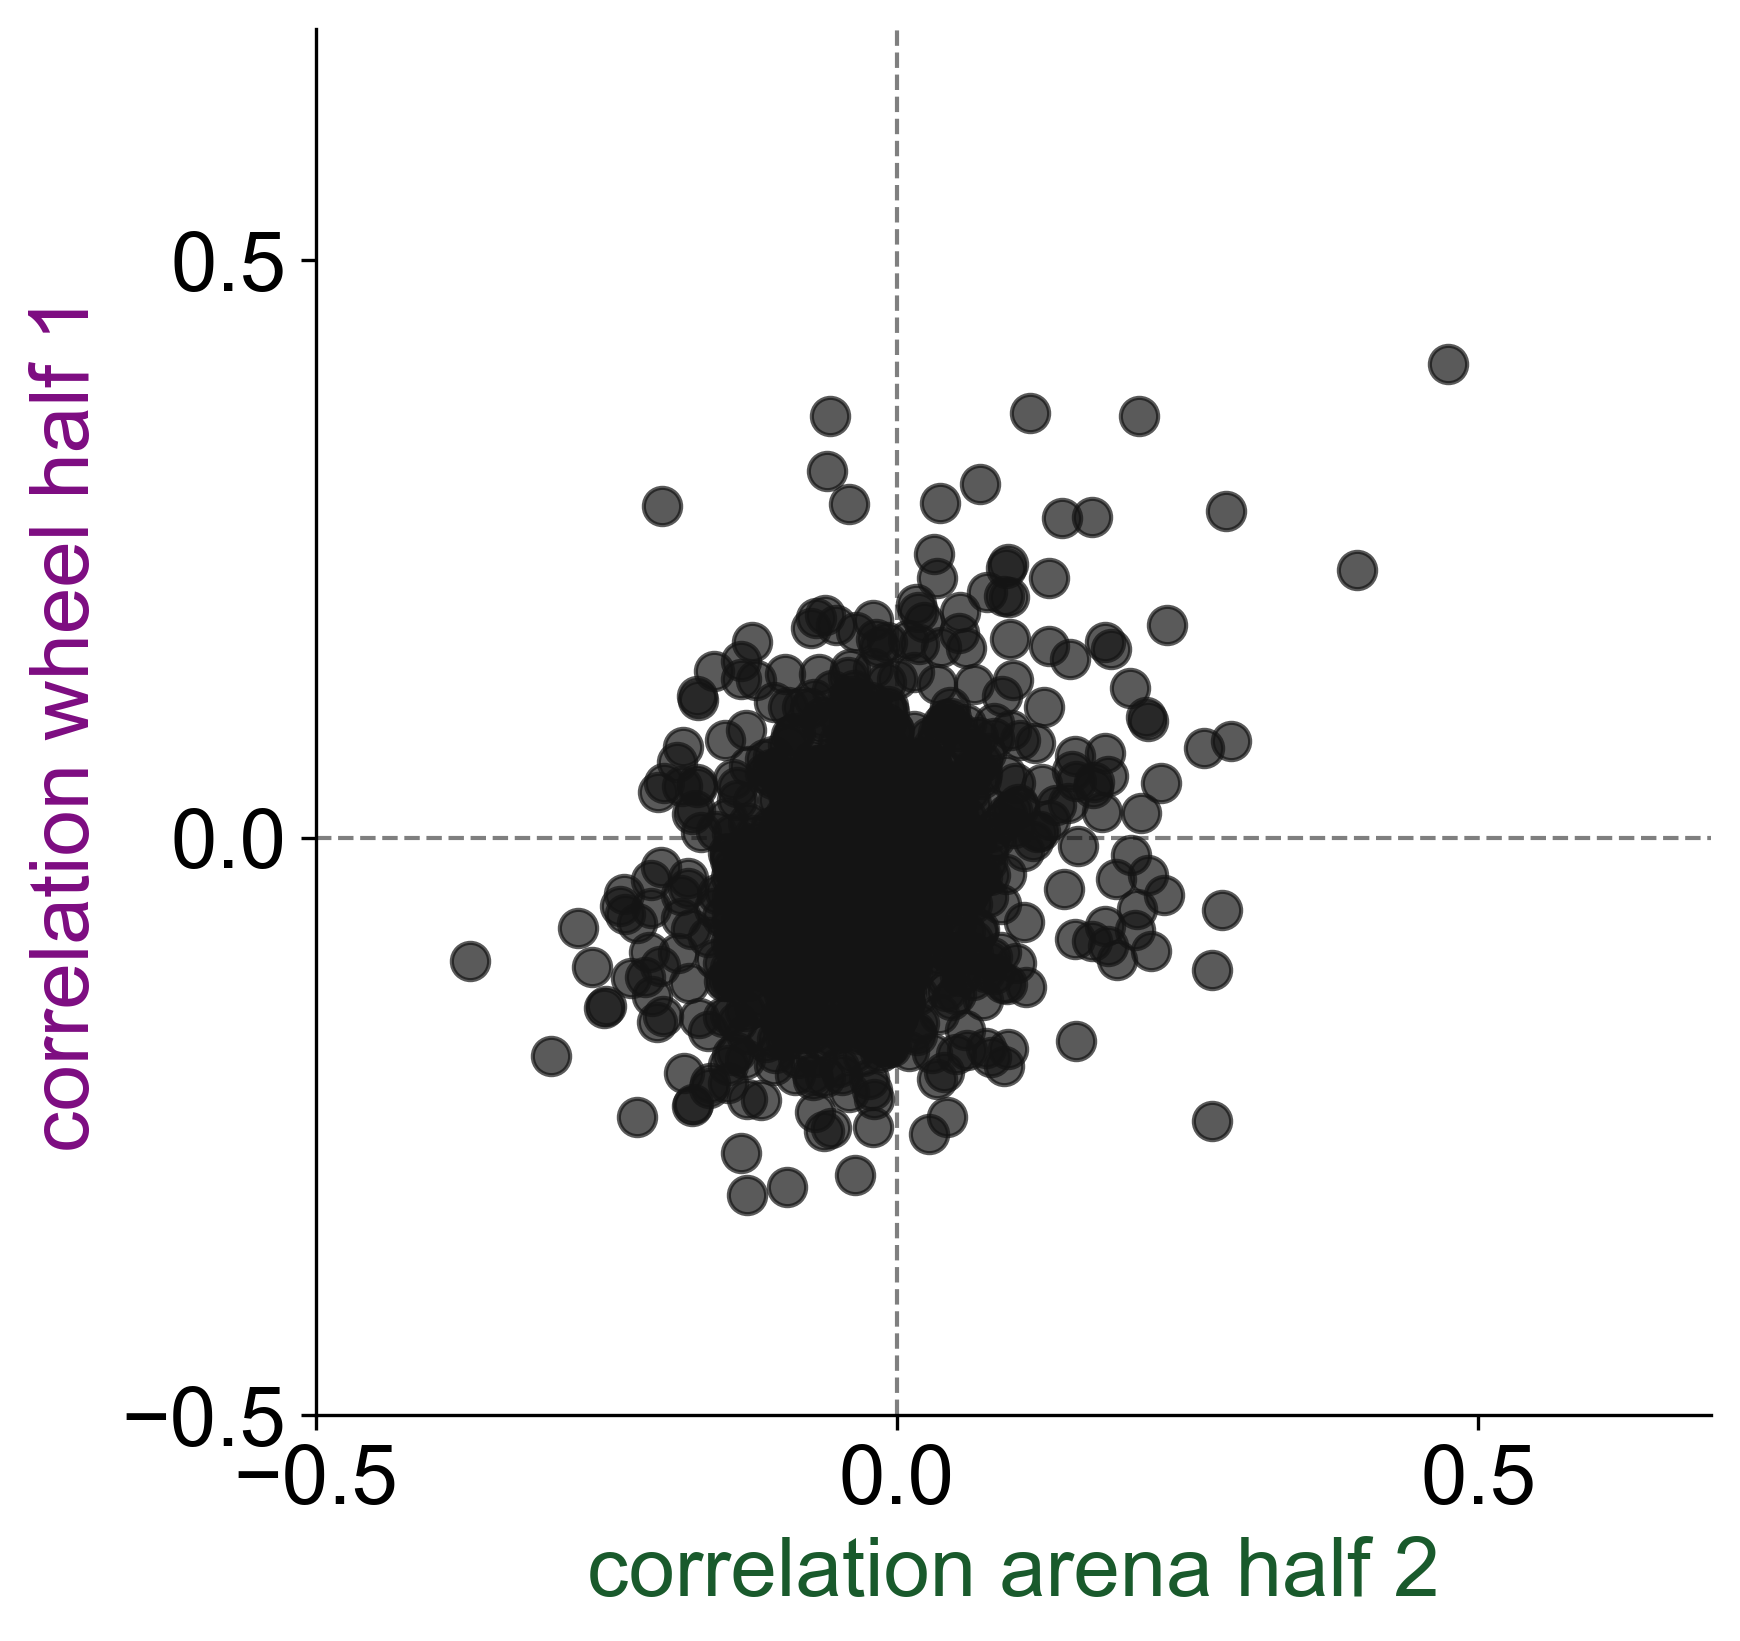

In [1181]:
fig, ax = plt.subplots(figsize=(6, 6),dpi=300)
ax.scatter(results[18].correlations.arena_half2, results[18].correlations.wheel_half1, alpha=0.7, color="#141414", zorder=2, s=80)
ax.set_xlabel('correlation arena half 2', fontsize=20, color="#195A2C")
ax.set_ylabel('correlation wheel half 1', fontsize=20, color="#7D0C81")
ax.axhline(0, color='k', linewidth=1, alpha=0.5, zorder=1, ls='--')
ax.axvline(0, color='k', linewidth=1, alpha=0.5, zorder=1, ls='--')
ax.set_xlim(-0.5, 0.7)
ax.set_ylim(-0.5, 0.7)
ax.set_xticks(np.arange(-0.5, 0.51, 0.5))  
ax.set_yticks(np.arange(-0.5, 0.51, 0.5))
ax.tick_params(axis='both', labelsize=20)
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\correlation_arenahalf2_wheelhalf1_MOs.png', bbox_inches='tight', dpi=300)

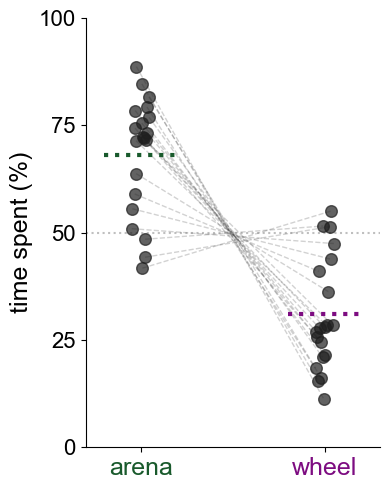

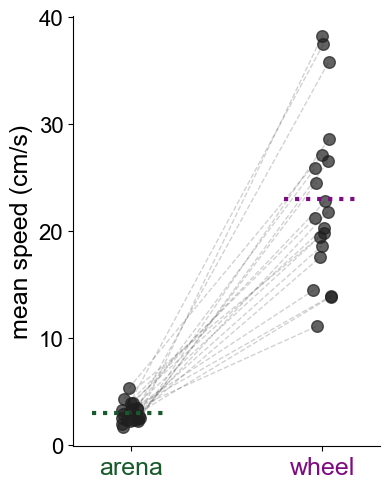

In [58]:
plot_context_preference(results)
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\time_in_context.svg', bbox_inches='tight', dpi=300)
plot_mean_speed_comparison(results)
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\mean_speed.svg', bbox_inches='tight', dpi=300)




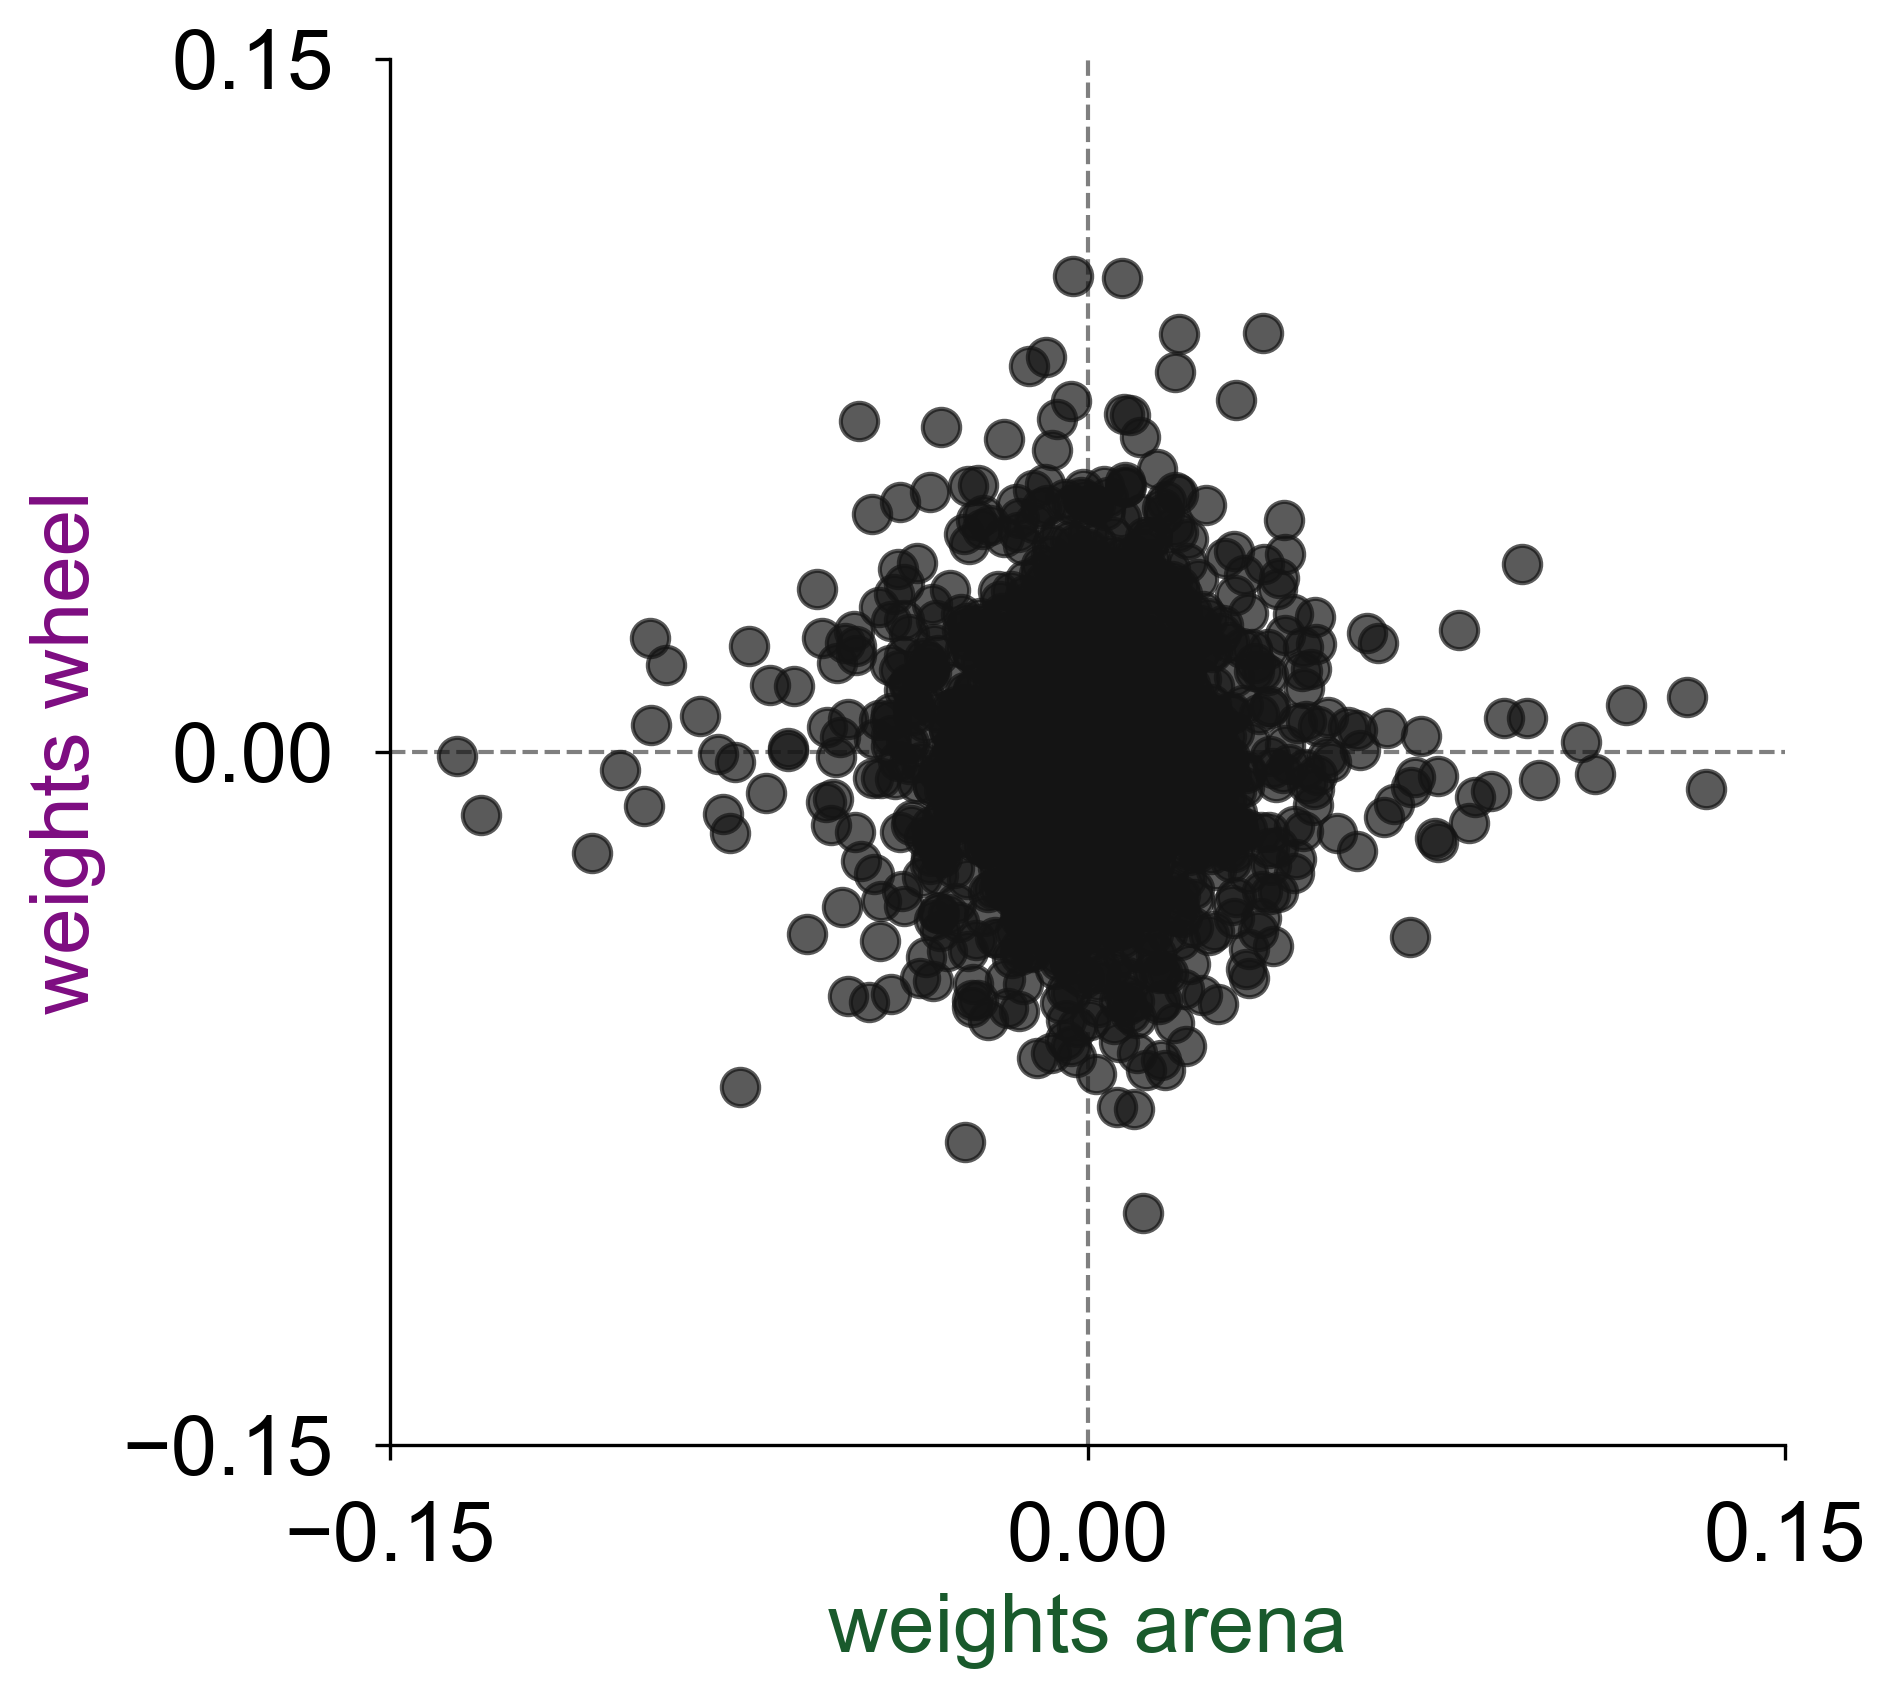

In [1275]:
fig, ax = plt.subplots(figsize=(6, 6),dpi=300)
ax.scatter(results[18].decoding.weights.arena, results[18].decoding.weights.wheel, alpha=0.7, color="#141414", zorder=2, s=80)
ax.set_xlabel('weights arena', fontsize=20, color="#195A2C")
ax.set_ylabel('weights wheel', fontsize=20, color="#7D0C81")
ax.axhline(0, color='k', linewidth=1, alpha=0.5, zorder=1, ls='--')
ax.axvline(0, color='k', linewidth=1, alpha=0.5, zorder=1, ls='--')
ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)
ax.set_xticks(np.arange(-0.15, 0.151, 0.15))  
ax.set_yticks(np.arange(-0.15, 0.151, 0.15))
ax.tick_params(axis='x', pad=10) 
ax.tick_params(axis='y', pad=10)
ax.tick_params(axis='both', labelsize=20)
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\weight_correlation.png', bbox_inches='tight', dpi=300)

In [1193]:
s=19


measured_speed = results[s].decoding.test_data.speed_arena
within_context_pred =results[s].decoding.prediction.arena_to_arena
between_context_pred = results[s].decoding.prediction.wheel_to_arena


In [1194]:
w_start=0
w_end =w_start+500
color = "#7D0C81"

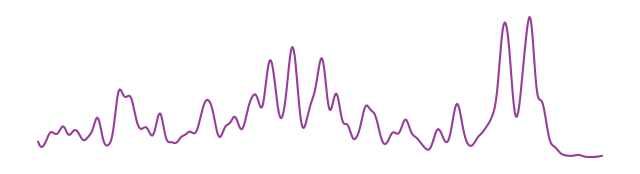

In [1195]:

fig, ax1 = plt.subplots(1, 1, figsize=(8, 2))
        
    # Plot velocities
ax1.plot(measured_speed[w_start:w_end], color=color, alpha=0.8)
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\observed_wheel.png', bbox_inches='tight', dpi=300)


    

    



In [1196]:
print(results[s].decoding.performance.arena_to_arena)
print(results[s].decoding.performance.wheel_to_arena)

[[1.         0.60347383]
 [0.60347383 1.        ]]
[[1.         0.07657189]
 [0.07657189 1.        ]]


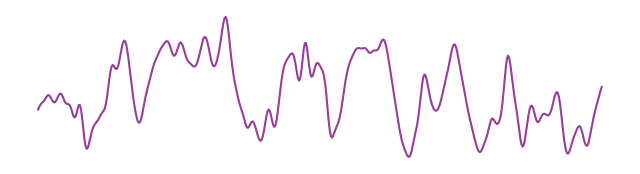

In [97]:
fig, ax2 = plt.subplots(1, 1, figsize=(8, 2))
        
ax2.plot(within_context_pred[w_start:w_end], color=color, alpha=0.8)
ax2.set_xticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\predicted_wheel_wheel.png', bbox_inches='tight', dpi=300)


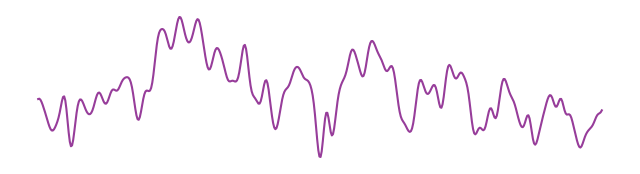

In [98]:
fig, ax3 = plt.subplots(1, 1, figsize=(8, 2))

ax3.plot(between_context_pred[w_start:w_end], color=color, alpha=0.8)
ax3.set_xticklabels([])
ax3.set_xticks([])
ax3.set_yticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
    # Add horizontal text label for Wheel Model (positioned outside plot area)
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\predicted_arena_wheel.png', bbox_inches='tight', dpi=300)


    


In [1541]:
print(np.corrcoef(results[s].decoding.test_data.speed_wheel, results[s].decoding.prediction.within_context.wheel)[0,1])

0.7817421059084619


In [1542]:
print(np.corrcoef(results[s].decoding.test_data.speed_wheel, results[s].decoding.prediction.cross_context.arena_to_wheel)[0,1])

0.5205451989590072


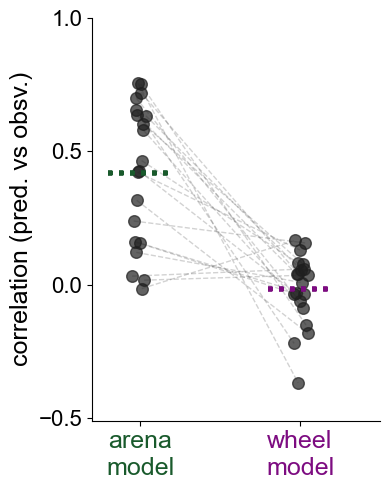

In [1286]:
# First, collect correlations from all sessions
corr_arena_list = []
corr_wheel_to_arena_list = []
brain_regions = []

for session in results:
    if result.spike_counts is None:
             continue
    if session.decoding is None:
        continue
    
    # Compute correlations if not already done
    test_data = session.decoding.test_data
    predictions = session.decoding.prediction
    
    # Within-context arena correlation
    corr_arena = np.corrcoef(test_data.speed_arena, predictions.arena_to_arena)[0, 1]
    
    # Cross-context wheel->arena correlation
    corr_wheel_to_arena = np.corrcoef(test_data.speed_arena, predictions.wheel_to_arena)[0, 1]
    
    corr_arena_list.append(corr_arena)
    corr_wheel_to_arena_list.append(corr_wheel_to_arena)

    if session.metadata.subject_id[:2] == 'EB':
            brain_regions.append('Hippocampus')
    else:
            brain_regions.append('Secondary Motor Cortex')

# Convert to arrays
corr_arena = np.array(corr_arena_list)
corr_wheel_to_arena = np.array(corr_wheel_to_arena_list)

# Calculate means
mean_arena = np.mean(corr_arena)
mean_wheel = np.mean(corr_wheel_to_arena)

# Create the plot
fig, ax = plt.subplots(figsize=(4, 5))

# Plot individual sessions
for i in range(len(corr_arena)):
    if brain_regions[i] == 'Hippocampus':
        color = "#1F1F1F"# Arena color
    else:
        color = "#1F1F1F"  # Wheel color
    jitter = np.random.uniform(-0.05, 0.05, 2)
    
    # Plot the connecting line with lower alpha
    ax.plot([0 + jitter[0], 1 + jitter[1]], [corr_arena[i], corr_wheel_to_arena[i]], 
            '--', color="#1F1F1F", alpha=0.2, linewidth=1)
    
    # Plot the dots with higher alpha
    ax.scatter([0 + jitter[0], 1 + jitter[1]], [corr_arena[i], corr_wheel_to_arena[i]], 
               color=color, alpha=0.7, s=70, zorder=3)

    # Mean lines with arena/wheel colors
    ax.plot([-0.2, 0.2], [mean_arena, mean_arena], 
            color='#195A2C', linewidth=3, zorder=5, ls='dotted')
    ax.plot([0.8, 1.2], [mean_wheel, mean_wheel], 
            color='#7D0C81', linewidth=3, zorder=5, ls='dotted')

# Formatting
ax.set_xlim(-0.3, 1.5)
ax.set_ylim(-0.51, 1)
ax.set_yticks(np.arange(-0.5, 1.1, 0.5))
ax.set_xticks([0, 1])
ax.set_xticklabels(['arena\nmodel', 'wheel\nmodel'], fontsize=18)

# Color the x-tick labels
xcolors = ["#195A2C", "#7D0C81"]
for xtick, xcolor in zip(ax.get_xticklabels(), xcolors):
    xtick.set_color(xcolor)

ax.xaxis.set_label_coords(0.125, -0.02)  
ax.set_ylabel('correlation (pred. vs obsv.)', fontsize=18)

#ax.set_title('arena', fontsize=18, color='#195A2C', loc='center', fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', labelsize=16)

plt.rcParams['font.sans-serif'] = ['Arial']
plt.tight_layout()
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\decoding_comparison_arena_with_brain_regions.svg', bbox_inches='tight', dpi=300)

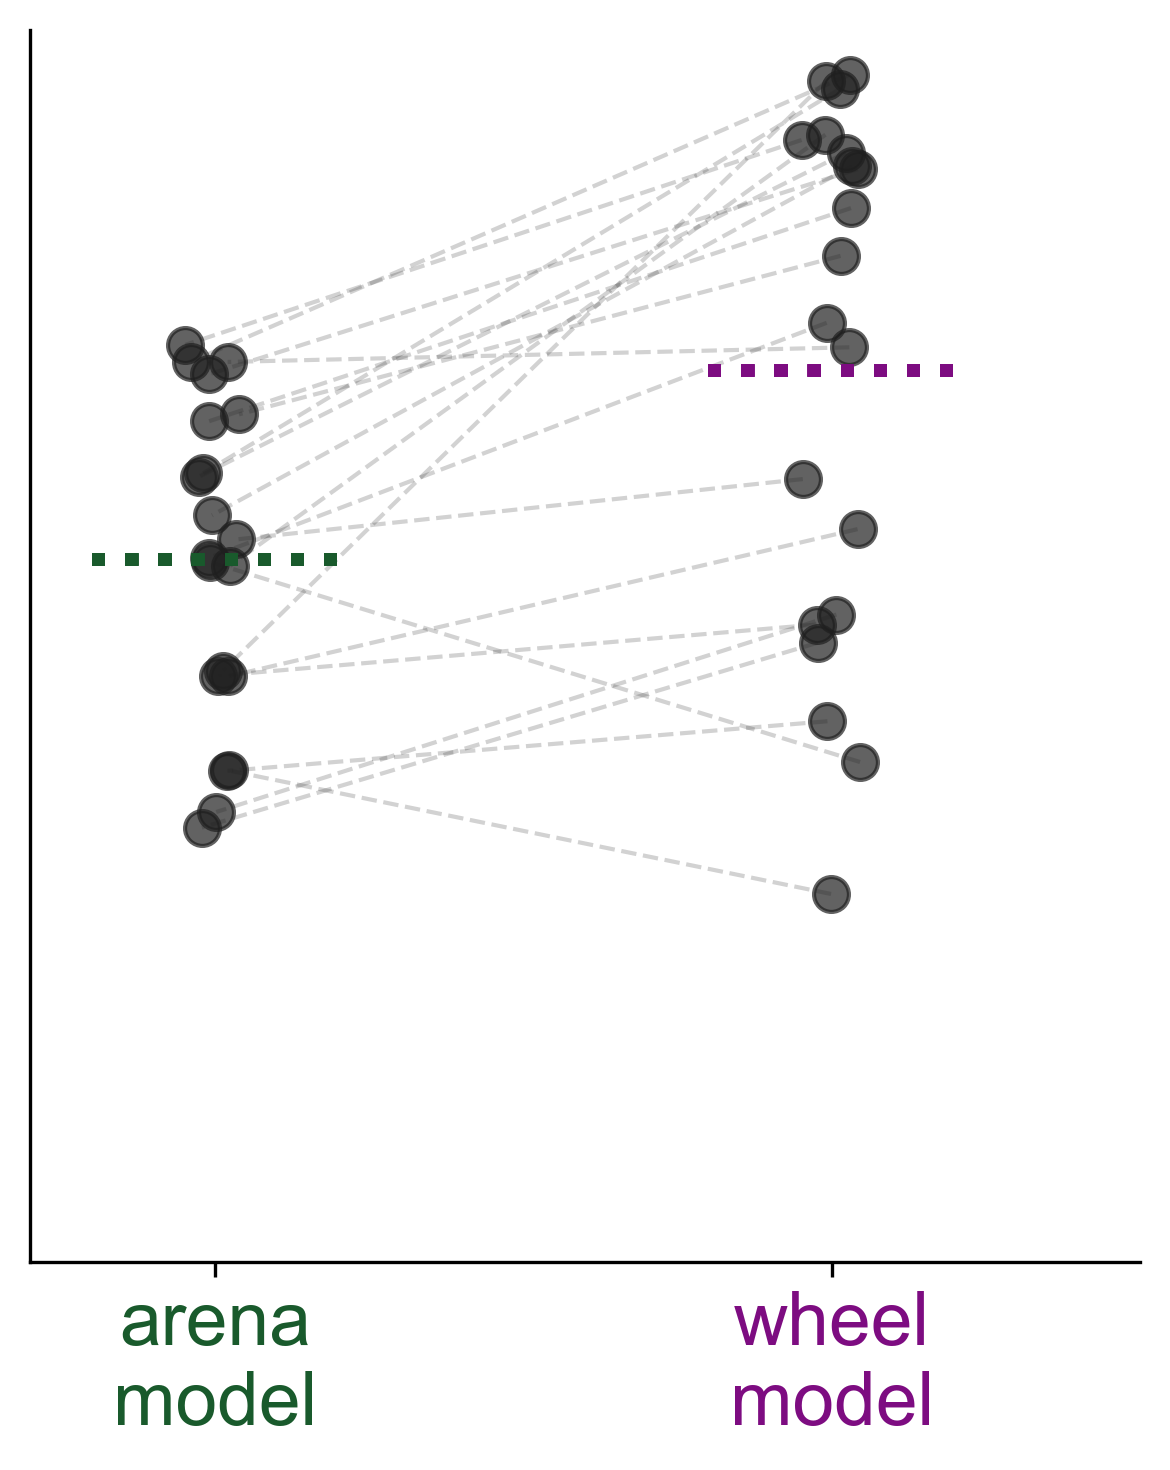

In [1281]:
# First, collect correlations from all sessions
corr_wheel_list = []
corr_arena_to_wheel_list = []
brain_regions = []

for session in results:
    if result.spike_counts is None:
             continue
    if session.decoding is None:
        continue
    
    # Compute correlations if not already done
    test_data = session.decoding.test_data
    predictions = session.decoding.prediction
    
    # Within-context wheel correlation
    corr_wheel = np.corrcoef(test_data.speed_wheel, predictions.wheel_to_wheel)[0, 1]
    
    # Cross-context arena->wheel correlation
    corr_arena_to_wheel = np.corrcoef(test_data.speed_wheel, predictions.arena_to_wheel)[0, 1]
    
    corr_wheel_list.append(corr_wheel)
    corr_arena_to_wheel_list.append(corr_arena_to_wheel)

    if session.metadata.subject_id[:2] == 'EB':
            brain_regions.append('HC')
    else:
        brain_regions.append('MOs')

# Convert to arrays
corr_wheel = np.array(corr_wheel_list)
corr_arena_to_wheel = np.array(corr_arena_to_wheel_list)

# Calculate means
mean_wheel = np.mean(corr_wheel)
mean_arena = np.mean(corr_arena_to_wheel)

# Create the plot
fig, ax = plt.subplots(figsize=(4, 5),dpi=300)



# Plot individual sessions
for i in range(len(corr_wheel)):
    color = "#1F1F1F"
    jitter = np.random.uniform(-0.05, 0.05, 2)
    
    # Plot the connecting line with lower alpha
    ax.plot([1 + jitter[1], 0 + jitter[0]], [corr_wheel[i], corr_arena_to_wheel[i]], 
            '--', color=color, alpha=0.2, linewidth=1)
    
    # Plot the dots with higher alpha
    ax.scatter([1 + jitter[1], 0 + jitter[0]], [corr_wheel[i], corr_arena_to_wheel[i]], 
               color=color, alpha=0.7, s=70, zorder=3)

    # Mean lines with arena/wheel colors
    ax.plot([0.8, 1.2], [mean_wheel, mean_wheel], 
            color='#7D0C81', linewidth=3, zorder=5, ls='dotted')
    ax.plot([-0.2, 0.2], [mean_arena, mean_arena], 
            color='#195A2C', linewidth=3, zorder=5, ls='dotted')

# Formatting
ax.set_xlim(-0.3, 1.5)
ax.set_ylim(-0.51, 1)
ax.set_yticks([])
ax.set_xticks([0, 1])
ax.set_xticklabels(['arena\nmodel', 'wheel\nmodel'], fontsize=18)

# Color the x-tick labels
xcolors = ["#195A2C", "#7D0C81"]
for xtick, xcolor in zip(ax.get_xticklabels(), xcolors):
    xtick.set_color(xcolor)

ax.xaxis.set_label_coords(0.125, -0.02)  
#ax.set_ylabel('correlation (predicted vs observed)', fontsize=12)
ax.yaxis.set_label_coords(-0.12, 0.5)  


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', labelsize=14)

plt.rcParams['font.sans-serif'] = ['Arial']
plt.tight_layout()
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\decoding_comparison_wheel_brain_regions.png', bbox_inches='tight', dpi=300)

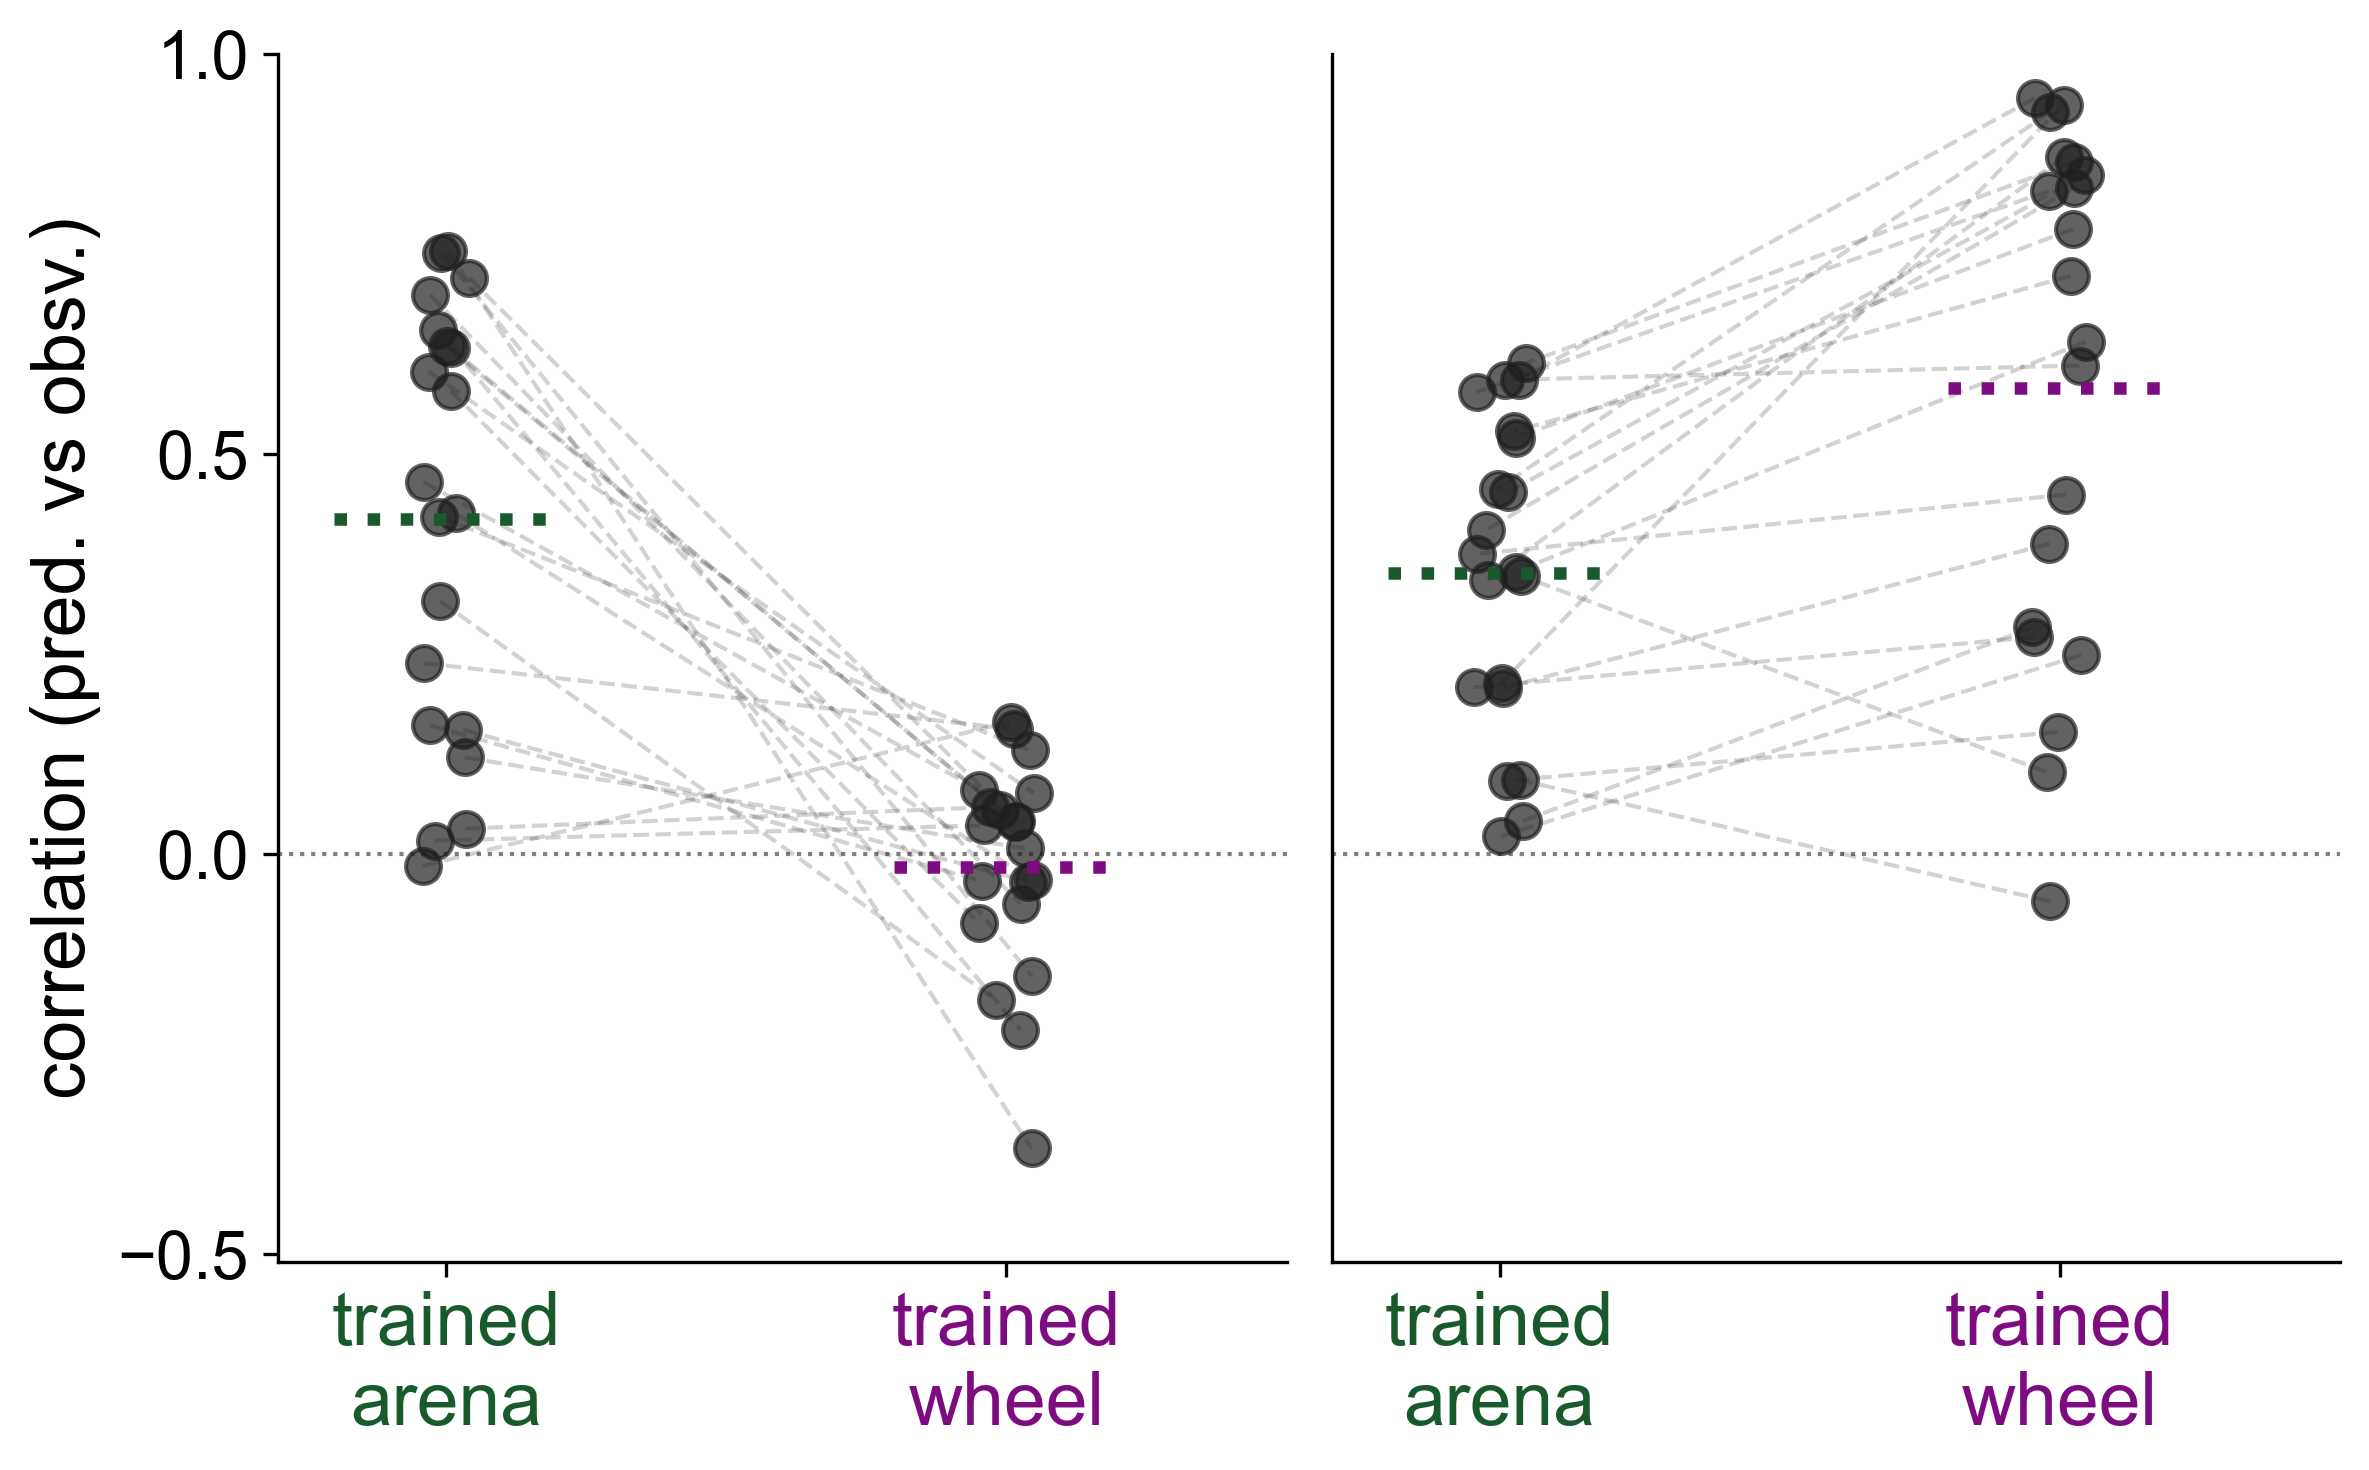

In [ ]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), dpi=300)

# FIRST PLOT - ARENA
# First, collect correlations from all sessions
corr_arena_list = []
corr_wheel_to_arena_list = []
brain_regions = []

for session in results:
    if session.decoding is None:
        continue
    
    # Compute correlations if not already done
    test_data = session.decoding.test_data
    predictions = session.decoding.prediction
    
    # Within-context arena correlation
    corr_arena = np.corrcoef(test_data.speed_arena, predictions.arena_to_arena)[0, 1]
    
    # Cross-context wheel->arena correlation
    corr_wheel_to_arena = np.corrcoef(test_data.speed_arena, predictions.wheel_to_arena)[0, 1]
    
    corr_arena_list.append(corr_arena)
    corr_wheel_to_arena_list.append(corr_wheel_to_arena)
    
    if session.metadata.subject_id[:2] == 'EB':
        brain_regions.append('Hippocampus')
    else:
        brain_regions.append('Secondary Motor Cortex')

# Convert to arrays
corr_arena = np.array(corr_arena_list)
corr_wheel_to_arena = np.array(corr_wheel_to_arena_list)

# Calculate means
mean_arena = np.mean(corr_arena)
mean_wheel = np.mean(corr_wheel_to_arena)

# Plot individual sessions
for i in range(len(corr_arena)):
    color = "#1F1F1F"
    jitter = np.random.uniform(-0.05, 0.05, 2)
    
    # Plot the connecting line with lower alpha
    ax1.plot([0 + jitter[0], 1 + jitter[1]], [corr_arena[i], corr_wheel_to_arena[i]], 
            '--', color="#1F1F1F", alpha=0.2, linewidth=1)
    
    # Plot the dots with higher alpha
    ax1.scatter([0 + jitter[0], 1 + jitter[1]], [corr_arena[i], corr_wheel_to_arena[i]], 
               color=color, alpha=0.7, s=70, zorder=3)

# Mean lines with arena/wheel colors
ax1.plot([-0.2, 0.2], [mean_arena, mean_arena], 
         color='#195A2C', linewidth=3, zorder=5, ls='dotted')
ax1.plot([0.8, 1.2], [mean_wheel, mean_wheel], 
         color='#7D0C81', linewidth=3, zorder=5, ls='dotted')

# Add horizontal line at 0
ax1.axhline(y=0, color="black", linestyle='dotted', linewidth=1, alpha=0.5)

# Formatting
ax1.set_xlim(-0.3, 1.5)
ax1.set_ylim(-0.51, 1)
ax1.set_yticks(np.arange(-0.5, 1.1, 0.5))
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['trained\narena', 'trained\nwheel'], fontsize=18)

# Color the x-tick labels
xcolors = ["#195A2C", "#7D0C81"]
for xtick, xcolor in zip(ax1.get_xticklabels(), xcolors):
    xtick.set_color(xcolor)

ax1.xaxis.set_label_coords(0.125, -0.02)
ax1.set_ylabel('correlation (pred. vs obsv.)', fontsize=18)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='y', labelsize=16)

# SECOND PLOT - WHEEL
corr_wheel_list = []
corr_arena_to_wheel_list = []
brain_regions = []

for session in results:
    if session.decoding is None:
        continue
    
    # Compute correlations if not already done
    test_data = session.decoding.test_data
    predictions = session.decoding.prediction
    
    # Within-context wheel correlation
    corr_wheel = np.corrcoef(test_data.speed_wheel, predictions.wheel_to_wheel)[0, 1]
    
    # Cross-context arena->wheel correlation
    corr_arena_to_wheel = np.corrcoef(test_data.speed_wheel, predictions.arena_to_wheel)[0, 1]
    
    corr_wheel_list.append(corr_wheel)
    corr_arena_to_wheel_list.append(corr_arena_to_wheel)
    
    if session.metadata.subject_id[:2] == 'EB':
        brain_regions.append('HC')
    else:
        brain_regions.append('MOs')

# Convert to arrays
corr_wheel = np.array(corr_wheel_list)
corr_arena_to_wheel = np.array(corr_arena_to_wheel_list)

# Calculate means
mean_wheel = np.mean(corr_wheel)
mean_arena = np.mean(corr_arena_to_wheel)

# Plot individual sessions
for i in range(len(corr_wheel)):
    color = "#1F1F1F"
    jitter = np.random.uniform(-0.05, 0.05, 2)
    
    # Plot the connecting line with lower alpha
    ax2.plot([1 + jitter[1], 0 + jitter[0]], [corr_wheel[i], corr_arena_to_wheel[i]], 
            '--', color=color, alpha=0.2, linewidth=1)
    
    # Plot the dots with higher alpha
    ax2.scatter([1 + jitter[1], 0 + jitter[0]], [corr_wheel[i], corr_arena_to_wheel[i]], 
               color=color, alpha=0.7, s=70, zorder=3)

# Mean lines with arena/wheel colors
ax2.plot([0.8, 1.2], [mean_wheel, mean_wheel], 
         color='#7D0C81', linewidth=3, zorder=5, ls='dotted')
ax2.plot([-0.2, 0.2], [mean_arena, mean_arena], 
         color='#195A2C', linewidth=3, zorder=5, ls='dotted')

# Add horizontal line at 0
ax2.axhline(y=0, color="black", linestyle='dotted', linewidth=1, alpha=0.5)

# Formatting
ax2.set_xlim(-0.3, 1.5)
ax2.set_ylim(-0.51, 1)
ax2.set_yticks([])
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['trained\narena', 'trained\nwheel'], fontsize=18)

# Color the x-tick labels
xcolors = ["#195A2C", "#7D0C81"]
for xtick, xcolor in zip(ax2.get_xticklabels(), xcolors):
    xtick.set_color(xcolor)

ax2.xaxis.set_label_coords(0.125, -0.02)
ax2.yaxis.set_label_coords(-0.12, 0.5)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y', labelsize=14)

plt.rcParams['font.sans-serif'] = ['Arial']
plt.tight_layout()
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\decoding_comparison_combined.svg', bbox_inches='tight', dpi=300)
plt.show()

In [41]:
hc_arena_correlations = []
sc_arena_correlations = []

for session in results:
    if session.correlations is None:
        continue
    arena_corr = session.correlations.arena
    wheel_corr = session.correlations.wheel
    if session.metadata.subject_id[:2] == 'EB':
        hc_arena_correlations.extend(arena_corr)
    else:
        sc_arena_correlations.extend(arena_corr)



In [40]:
hc_wheel_correlations = []
sc_wheel_correlations = []
for session in results:
    if session.correlations is None:
        continue
    arena_corr = session.correlations.arena
    wheel_corr = session.correlations.wheel
    if session.metadata.subject_id[:2] == 'EB':
        hc_wheel_correlations.extend(wheel_corr)
    else:
        sc_wheel_correlations.extend(wheel_corr)

In [614]:
print(mean_wheel)

-0.009035200245939836


In [150]:
import cv2
subject_id= 'AV043'
date= '2024-03-13'
metadata, behavior, spike_counts = load_session_data(subject_id, date, target_freq=60)
    
# Load DLC data
print("Loading DLC data...")
dlc_df = pd.read_hdf(fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}DLC_resnet50_downsampled_trialJul11shuffle1_150000_filtered.h5')
dlc_df = dlc_df.droplevel('scorer', axis=1)

No probe1 data found
Loading DLC data...


In [68]:
r = 17
speed_arena = results[r].behavior.speed_arena
speed_wheel = results[r].behavior.speed_wheel
mask_arena = results[r].behavior.mask_arena
mask_wheel = results[r].behavior.mask_wheel
spike_counts = results[r].spike_counts

In [84]:
def plot_context_speed_comparison(speed_arena, speed_wheel, mask_arena, mask_wheel):

    fig, ax =plt.subplots(1,1, figsize=(5, 5))
    ax.hist(speed_arena[mask_arena], color='#195A2C', bins=50, alpha=0.9, density=True)
    ax.hist(speed_wheel[mask_wheel], color='#7D0C81', bins=50, alpha=0.7, density=True )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('speed (cm/s)', fontsize=18)
    ax.set_ylabel('probability', fontsize=18)
    ax.set_xticks(np.arange(0,50.1,25))
    ax.tick_params(axis='both', labelsize=16)
    






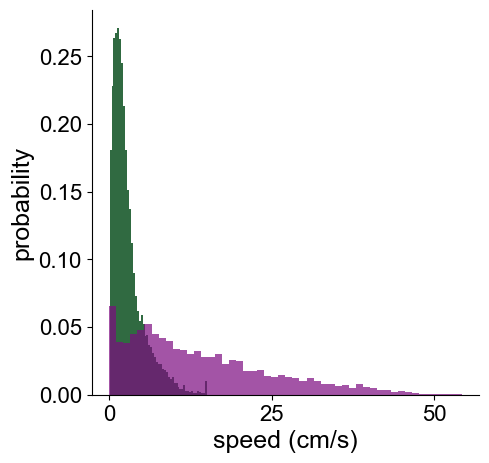

In [85]:
plot_context_speed_comparison(speed_arena, speed_wheel, mask_arena, mask_wheel)
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\speed_comparison.svg', bbox_inches='tight', dpi=300)

In [1164]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_multi_session_histograms(all_session_results, context='wheel', 
                                  figsize=(10, 6), save_path=None, save=False):
    """
    Plot correlation histograms for all sessions overlaid, separated by brain region.
    
    Parameters:
    -----------
    all_session_results : list
        List of session results from analyze_all_sessions
    context : str
        'arena' or 'wheel' - which correlations to plot
    """
    
    # Separate sessions by brain region
    hc_sessions = []
    mos_sessions = []
    
    for result in all_session_results:
        if result.spike_counts is None:
            continue
            
        if result.metadata.subject_id[:2] == 'EB':
            hc_sessions.append(result)
        else:
            mos_sessions.append(result)

    if len(hc_sessions) > 5:
        hc_sessions = random.sample(hc_sessions, 5)
    if len(mos_sessions) > 5:
        mos_sessions = random.sample(mos_sessions, 5)
    
    # Create figure with 2 subplots side by side
    fig, ( ax_mos, ax_hc) = plt.subplots(1, 2, figsize=figsize, sharey=True,dpi =300)
    
    # Plot all HC sessions overlaid
    for i, session in enumerate(hc_sessions):
        correlations = getattr(session.correlations, context)
        ax_hc.hist(correlations, bins=100, orientation='horizontal', 
               color='#195A2C', alpha=0.7, edgecolor='none',
               bottom=i*170) 
    
    # Plot all MOs sessions overlaid
    for i,session in enumerate(mos_sessions):
        correlations = getattr(session.correlations, context)
        ax_mos.hist(correlations, bins=100, orientation='horizontal', 
                    color='#195A2C',alpha=0.7,edgecolor='none',
               bottom=i*200)
    
    # Formatting for both axes
    for ax, label in zip([ax_hc, ax_mos], ['Hippocampus', 'Motor Cortex']):
        ax.set_ylim(-0.5, 0.5)
        ax.set_yticklabels(np.arange(-0.5, 0.51, 0.5), fontsize=12)
        ax.set_yticks(np.arange(-0.5, 0.51, 0.5))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        


        ax.axhline(0.0, color="#1F1F1F", linestyle='--', linewidth=1.5, alpha=0.5)
    
    # Only label y-axis on the left subplot
    ax_mos.set_ylabel('Pearson correlation', fontsize=14)
    ax_mos.spines
    # For HC subplot
    ax_hc.set_xticks([i*170  for i in range(len(hc_sessions))])
    ax_hc.set_xticklabels([f'HC{i+1}' for i in range(len(hc_sessions))], fontsize=12)
   

    # For MOs subplot  
    ax_mos.set_xticks([i*200 for i in range(len(mos_sessions))])
    ax_mos.set_xticklabels([f'MOs{i+1}' for i in range(len(mos_sessions))], fontsize=12)
    
    plt.tight_layout()
    
    if save and save_path:
        plt.savefig(fr'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\{save_path}.png', bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return fig




In [44]:
# Usage:
fig = plot_multi_session_histograms(results, context='arena', save_path='dist_random_5_arena', save=True)



NameError: name 'plot_multi_session_histograms' is not defined

In [1177]:
        
def plot_reliability_stability(all_session_results):
    

    fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)

    reliability_values = []
    stability_values = []
    brain_regions = []

    for result in all_session_results:
        if result.spike_counts is None:
             continue
        
        reliability_values.append(result.correlations.reliability)
        stability_values.append(result.correlations.stability)
        
    
        if result.metadata.subject_id == 'EB036':
            brain_regions.append('hippocampus')
        elif result.metadata.subject_id == 'EB037':
            brain_regions.append('striatum')
        else:
            brain_regions.append('secondary motor cortex')


    reliability_values = np.array(reliability_values)
    stability_values = np.array(stability_values)
    brain_regions = np.array(brain_regions)


    colors = {
        'hippocampus':"#A5CB5D",  
        'striatum':"#E37A2A",
        'secondary motor cortex':"#770F0F"
    }  
    for region in ['hippocampus', 'striatum', 'secondary motor cortex']:
        mask = brain_regions == region
        
        ax.scatter(reliability_values[mask], 
                stability_values[mask], 
                c=colors[region],
                s=150,  
                alpha=0.7,  
                edgecolors='none',  
                linewidth=0.5,
                label=region,
                zorder=3)

    ax.plot([0, 1], [0, 1], 'k-', linewidth=1, alpha=0.5, zorder=1, ls='--')

    ax.set_xlim(-0.10, 1.05)
    ax.set_ylim(-0.10, 1.05)

    ax.set_xlabel('reliability', fontsize=20)
    ax.set_ylabel('stability', fontsize=20)

    # Add legend
    legend = ax.legend(loc='upper left', 
                    frameon=False, 
                    fancybox=False,
                    edgecolor='black',
                    fontsize=18)
    legend.get_frame().set_linewidth(0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=20, width=1.5, length=6)


    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks(np.arange(0, 1.1, 0.5))
    ax.set_yticks(np.arange(0, 1.1, 0.5))
    plt.rcParams['font.sans-serif'] = ['Arial']

    plt.tight_layout()

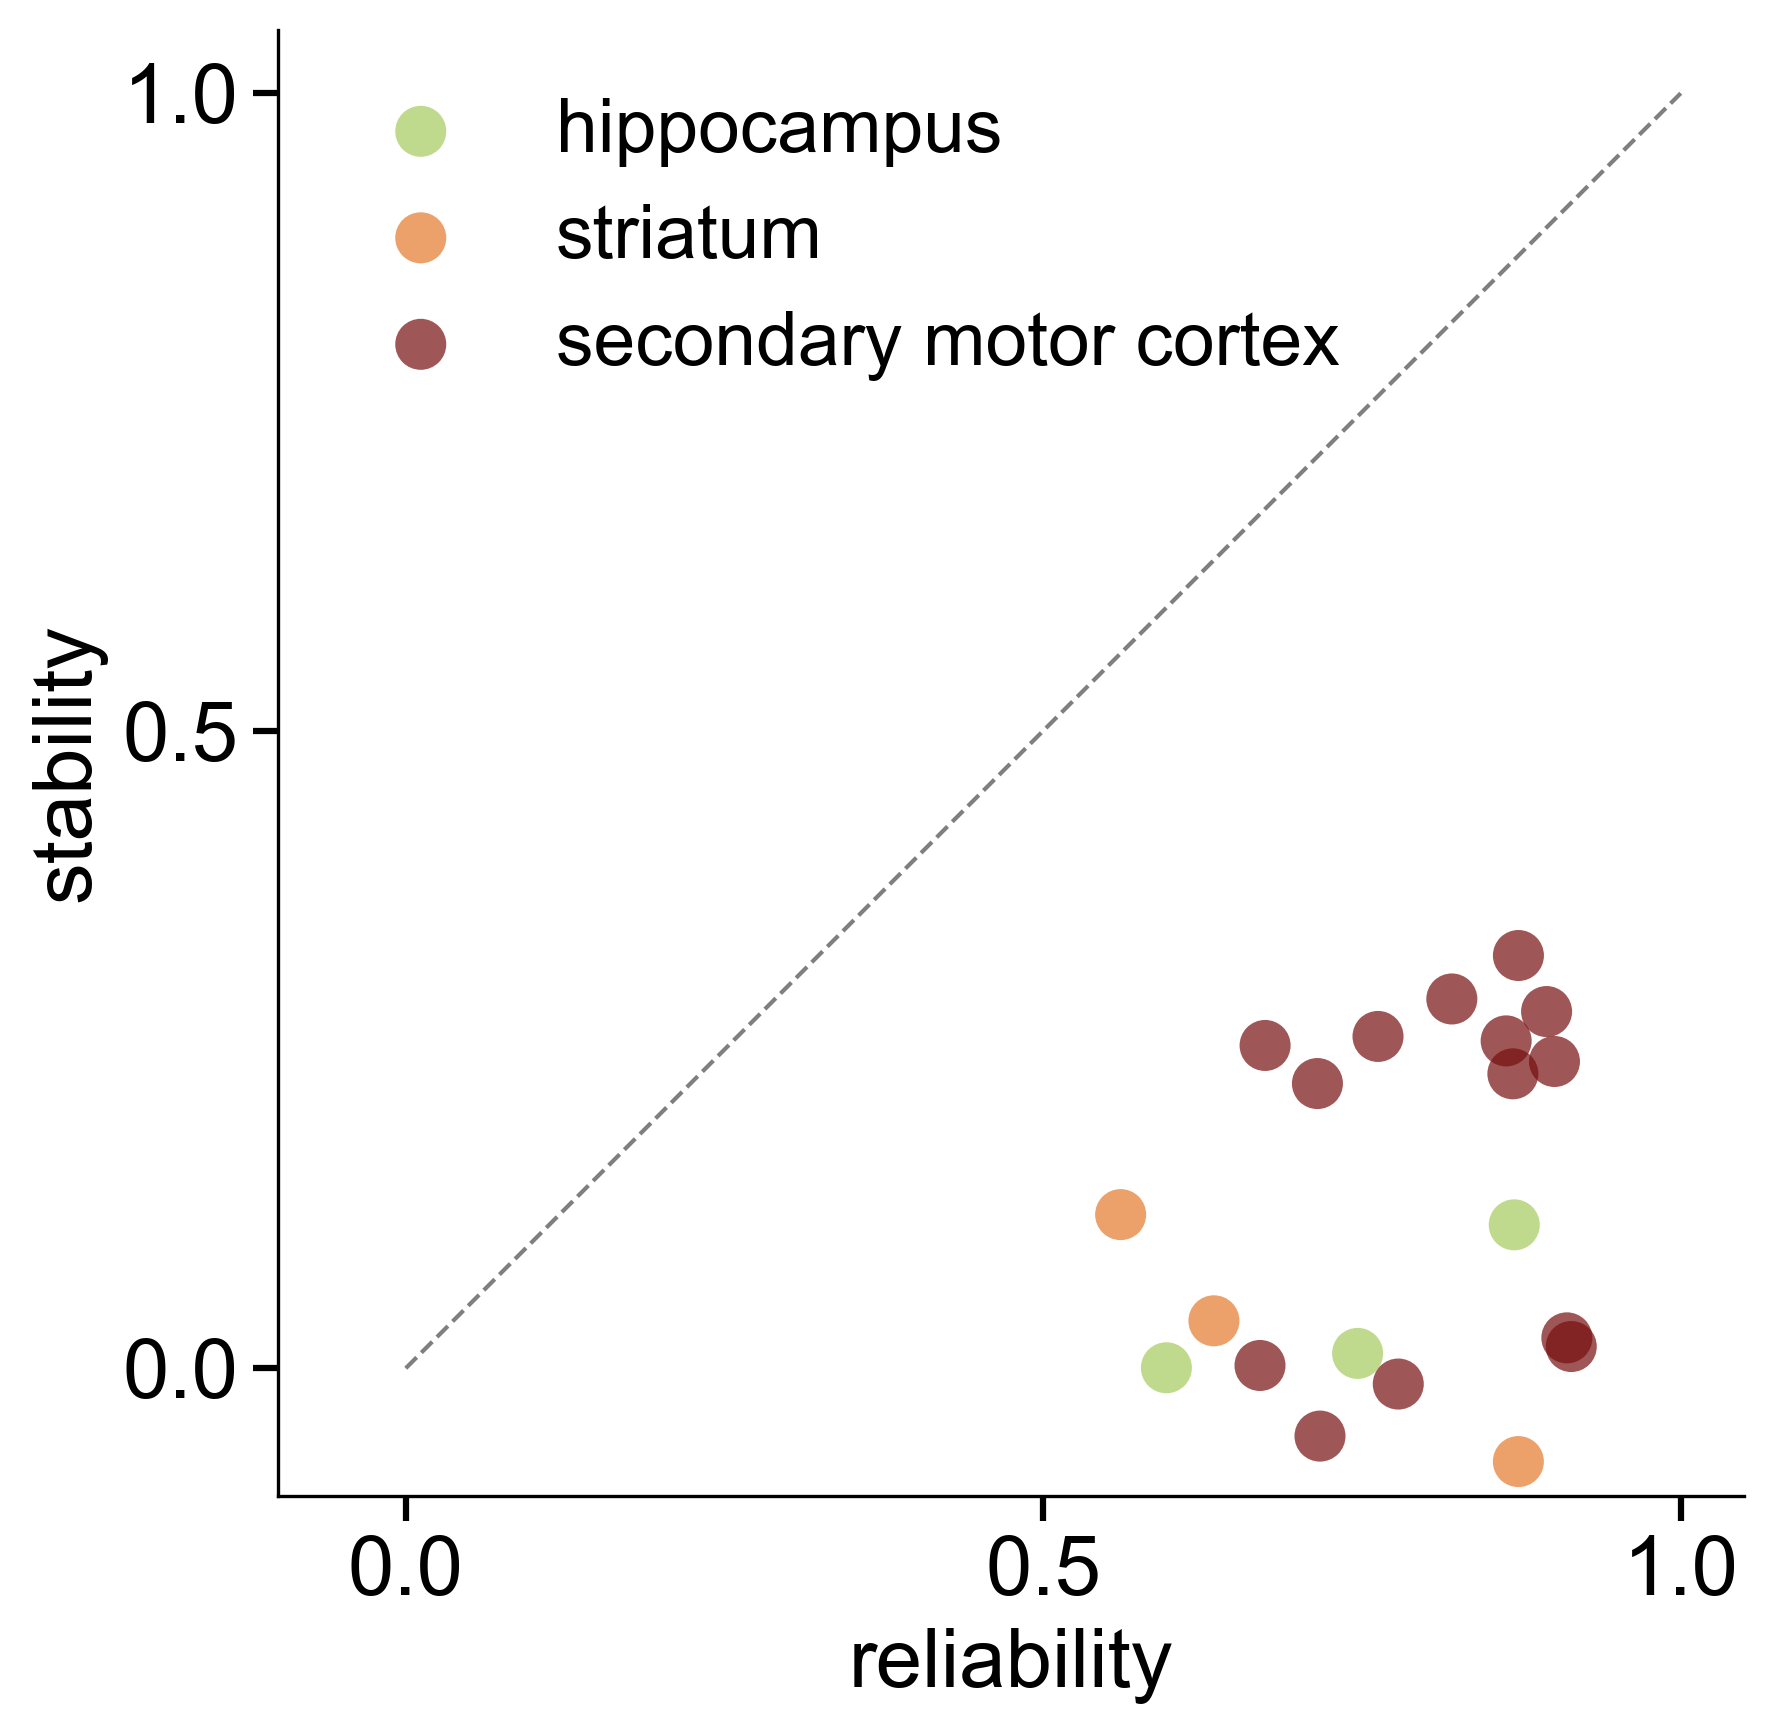

In [1178]:
plot_reliability_stability(results)
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\reliability_stability.png', bbox_inches ='tight', dpi=300)

TypeError: categorise_neurons() missing 3 required positional arguments: 'corr_wheel', 'sig_arena', and 'sig_wheel'

In [141]:
subject_id= 'AV043'
date= '2024-03-13'

In [145]:
video_path = fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}.mp4'

frame_idx= 1365
    

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()
cap.release()

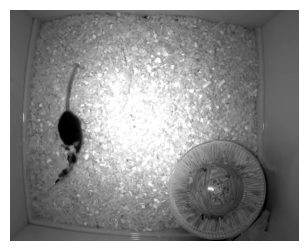

In [185]:
frame_idx = 1365
clean_frame= plt.subplots(figsize=(4, 3))
plt.imshow(frame)
plt.axis('off')
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\bland_frame.png', bbox_inches ='tight', dpi=300)


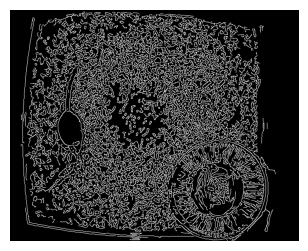

In [189]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 25, 50)

plt.figure(figsize=(4, 3))
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.savefig(rf'C:\Users\Experiment\Desktop\Leonard_Stuff\plots_for_pres\canny_frame.png', 
            bbox_inches='tight', dpi=300)



In [ ]:
import numpy as np

sessions_with_spikes = [s for s in sessions if s.spike_counts is not None]
print(f"Sessions with spike data: {len(sessions_with_spikes)}/{len(sessions)}")

error = []

for session in sessions_with_spikes:

    mask_wheel= session.behavior.mask_wheel
    mask_arena= session.behavior.mask_arena
    corner= session.behavior.corner
    displacement = np.diff(session.behavior.rotary_position)
    displacement= np.insert(displacement, 0, 0)


    wheel_moving = np.abs(displacement) > 0




    valid_data_mask = ~corner

    mask_wheel = mask_wheel[valid_data_mask]
    wheel_moving = wheel_moving[valid_data_mask]
    tp = np.sum(mask_wheel & wheel_moving)
    fn = np.sum(~mask_wheel & wheel_moving)
    bp = np.sum(mask_wheel & ~wheel_moving)
    tn = np.sum(~mask_wheel & ~wheel_moving)

    total_moving_time = tp + fn
    if total_moving_time > 0:
        critical_error_rate = fn / total_moving_time
        error.append(critical_error_rate)
        
    else:
        print("1. Critical Error Rate: N/A (No wheel movement was detected in the valid data.)\n")


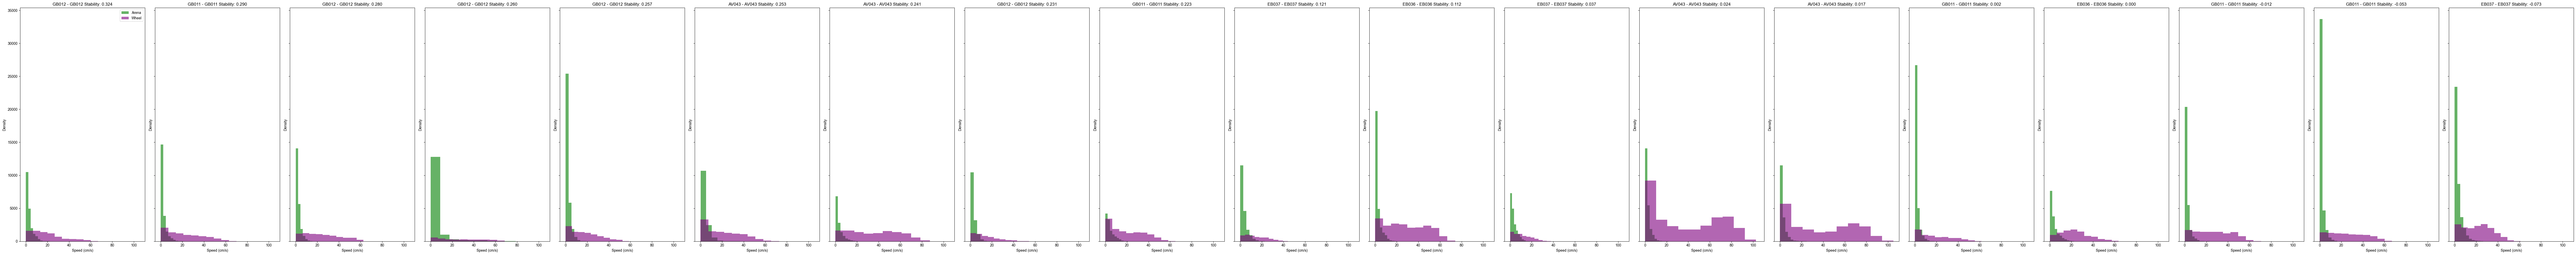

In [795]:
# Get stability scores as a list
stability_scores = [r.correlations.stability for r in results 
                   if hasattr(r.correlations, 'stability')]
subject_ids = [r.metadata.subject_id for r in results 
                   if hasattr(r.correlations, 'stability')]
dates = [r.metadata.subject_id for r in results 
                   if hasattr(r.correlations, 'stability')]
speed_arena= [r.behavior.speed_arena for r in results 
                   if hasattr(r.correlations, 'stability')]

speed_wheel= [r.behavior.speed_wheel for r in results 
                   if hasattr(r.correlations, 'stability')]

mask_arena= [r.behavior.mask_arena for r in results 
                   if hasattr(r.correlations, 'stability')]

mask_wheel= [r.behavior.mask_wheel for r in results 
                   if hasattr(r.correlations, 'stability')]


# Get masks for filtering speeds
mask_arena = [r.behavior.mask_arena for r in results 
              if hasattr(r.correlations, 'stability')]

mask_wheel = [r.behavior.mask_wheel for r in results 
              if hasattr(r.correlations, 'stability')]

# Sort everything by stability scores (highest to lowest)
sorted_indices = np.argsort(stability_scores)[::-1]

# Apply sorting to all lists
stability_scores = [stability_scores[i] for i in sorted_indices]
subject_ids = [subject_ids[i] for i in sorted_indices]
dates = [dates[i] for i in sorted_indices]
speed_arena = [speed_arena[i] for i in sorted_indices]
speed_wheel = [speed_wheel[i] for i in sorted_indices]
mask_arena = [mask_arena[i] for i in sorted_indices]
mask_wheel = [mask_wheel[i] for i in sorted_indices]





for idx in range(len(stability_scores)):

    arena_speed = speed_arena[idx][mask_arena[idx]]
    wheel_speed = speed_wheel[idx][mask_wheel[idx]]
    arena_counts, _ = np.histogram(arena_speed)
    wheel_counts, _ = np.histogram(wheel_speed)
    max_count = max(max_count, arena_counts.max(), wheel_counts.max())

# Setup plot
n = len(stability_scores)
n_cols = 19
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(100, 10), 
                         sharey=True, sharex=True)  # Share both axes
axes = axes.flatten() if n > 1 else [axes]

# Plot each session
for idx in range(n):
    ax = axes[idx]
    
    # Get speeds for each context using masks
    arena_speed = speed_arena[idx][mask_arena[idx]]
    wheel_speed = speed_wheel[idx][mask_wheel[idx]]
    
    # Plot distributions
    ax.hist(arena_speed, alpha=0.6, color='green', label='Arena')
    ax.hist(wheel_speed, alpha=0.6, color='purple', label='Wheel')

    
    
    ax.set_title(f'{subject_ids[idx]} - {dates[idx]} Stability: {stability_scores[idx]:.3f}')
    ax.set_xlabel('Speed (cm/s)')
    ax.set_ylabel('Density')
    if idx == 0:
        ax.legend()

# Hide unused subplots
for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
all_decoding = analyze_all_sessions(my_sessions,correlation=False, decoding=True, leaveout=False)

In [ ]:
sixseven = all_decoding[9]
print(sixseven.decoding.performance.within_context.wheel)
print(sixseven.decoding.performance.within_context.arena)

In [ ]:
subject_id = 'GB012'
date= '2024-06-19'

metadata, behavior, spike_counts = load_session_data(subject_id, date)
    


In [ ]:
# Run analyses
correlation_results = perform_correlation_analyses(behavior, spike_counts)


In [ ]:
speed_arena = behavior.speed_arena
print(speed_arena)
speed_wheel= behavior.speed_wheel

mask_arena = behavior.mask_arena
mask_wheel = behavior.mask_wheel

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.hist(speed_arena[mask_arena], alpha=0.7, color="#23974a", bins=30)
ax.hist(speed_wheel[mask_wheel],alpha=0.7, color="#b435da", bins=30)
ax.set_xlabel('Speed Arena cm/s', fontsize=10)
ax.set_ylabel('Counts', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
fig.show()

In [ ]:
ax.hist(speed_arena, alpha=0.7, color=color, bins=30)
ax.set_xlabel('Pearson correlation', fontsize=10)
ax.set_ylabel('Number of neurons', fontsize=10)
ax.set_xticks(np.arange(-0.5, 0.505, 0.5))
ax.set_yticks(np.arange(0,100.05, 50))
ax.tick_params(axis='both', labelsize=10)
fig.show()

In [ ]:
decoding_results = perform_decoding_analyses(behavior, spike_counts, 
                                                leaveout=True, alpha=1.0)

In [ ]:
stability 